# Создание простого LLM в стиле GPT для вопросов и ответов с нуля

*Хорошим ресурсом для использования вместе с этим блокнотом является оригинал [GPT paper](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). Этот блокнот в значительной степени опирается на эту статью в отношении архитектуры моделей и их реализации.*


В этой статье мы рассмотрим процесс построения простой модели в стиле GPT с нуля с использованием pytorch. Цель этой статьи — обучить базовую большую языковую модель от начала до конца в одном ноутбуке. Мы обучим LLM, которая будет достаточно компактной, чтобы поместиться на одном GPU во время обучения и инференции, поэтому ноутбук можно будет запускать в популярных облачных GPU-сервисах (Google Colab, Kaggle, Paperspace и т. д.). Вычислительный граф модели, которую мы создадим в этой статье, выглядит следующим образом:

<div style="width:500px;margin:auto;">

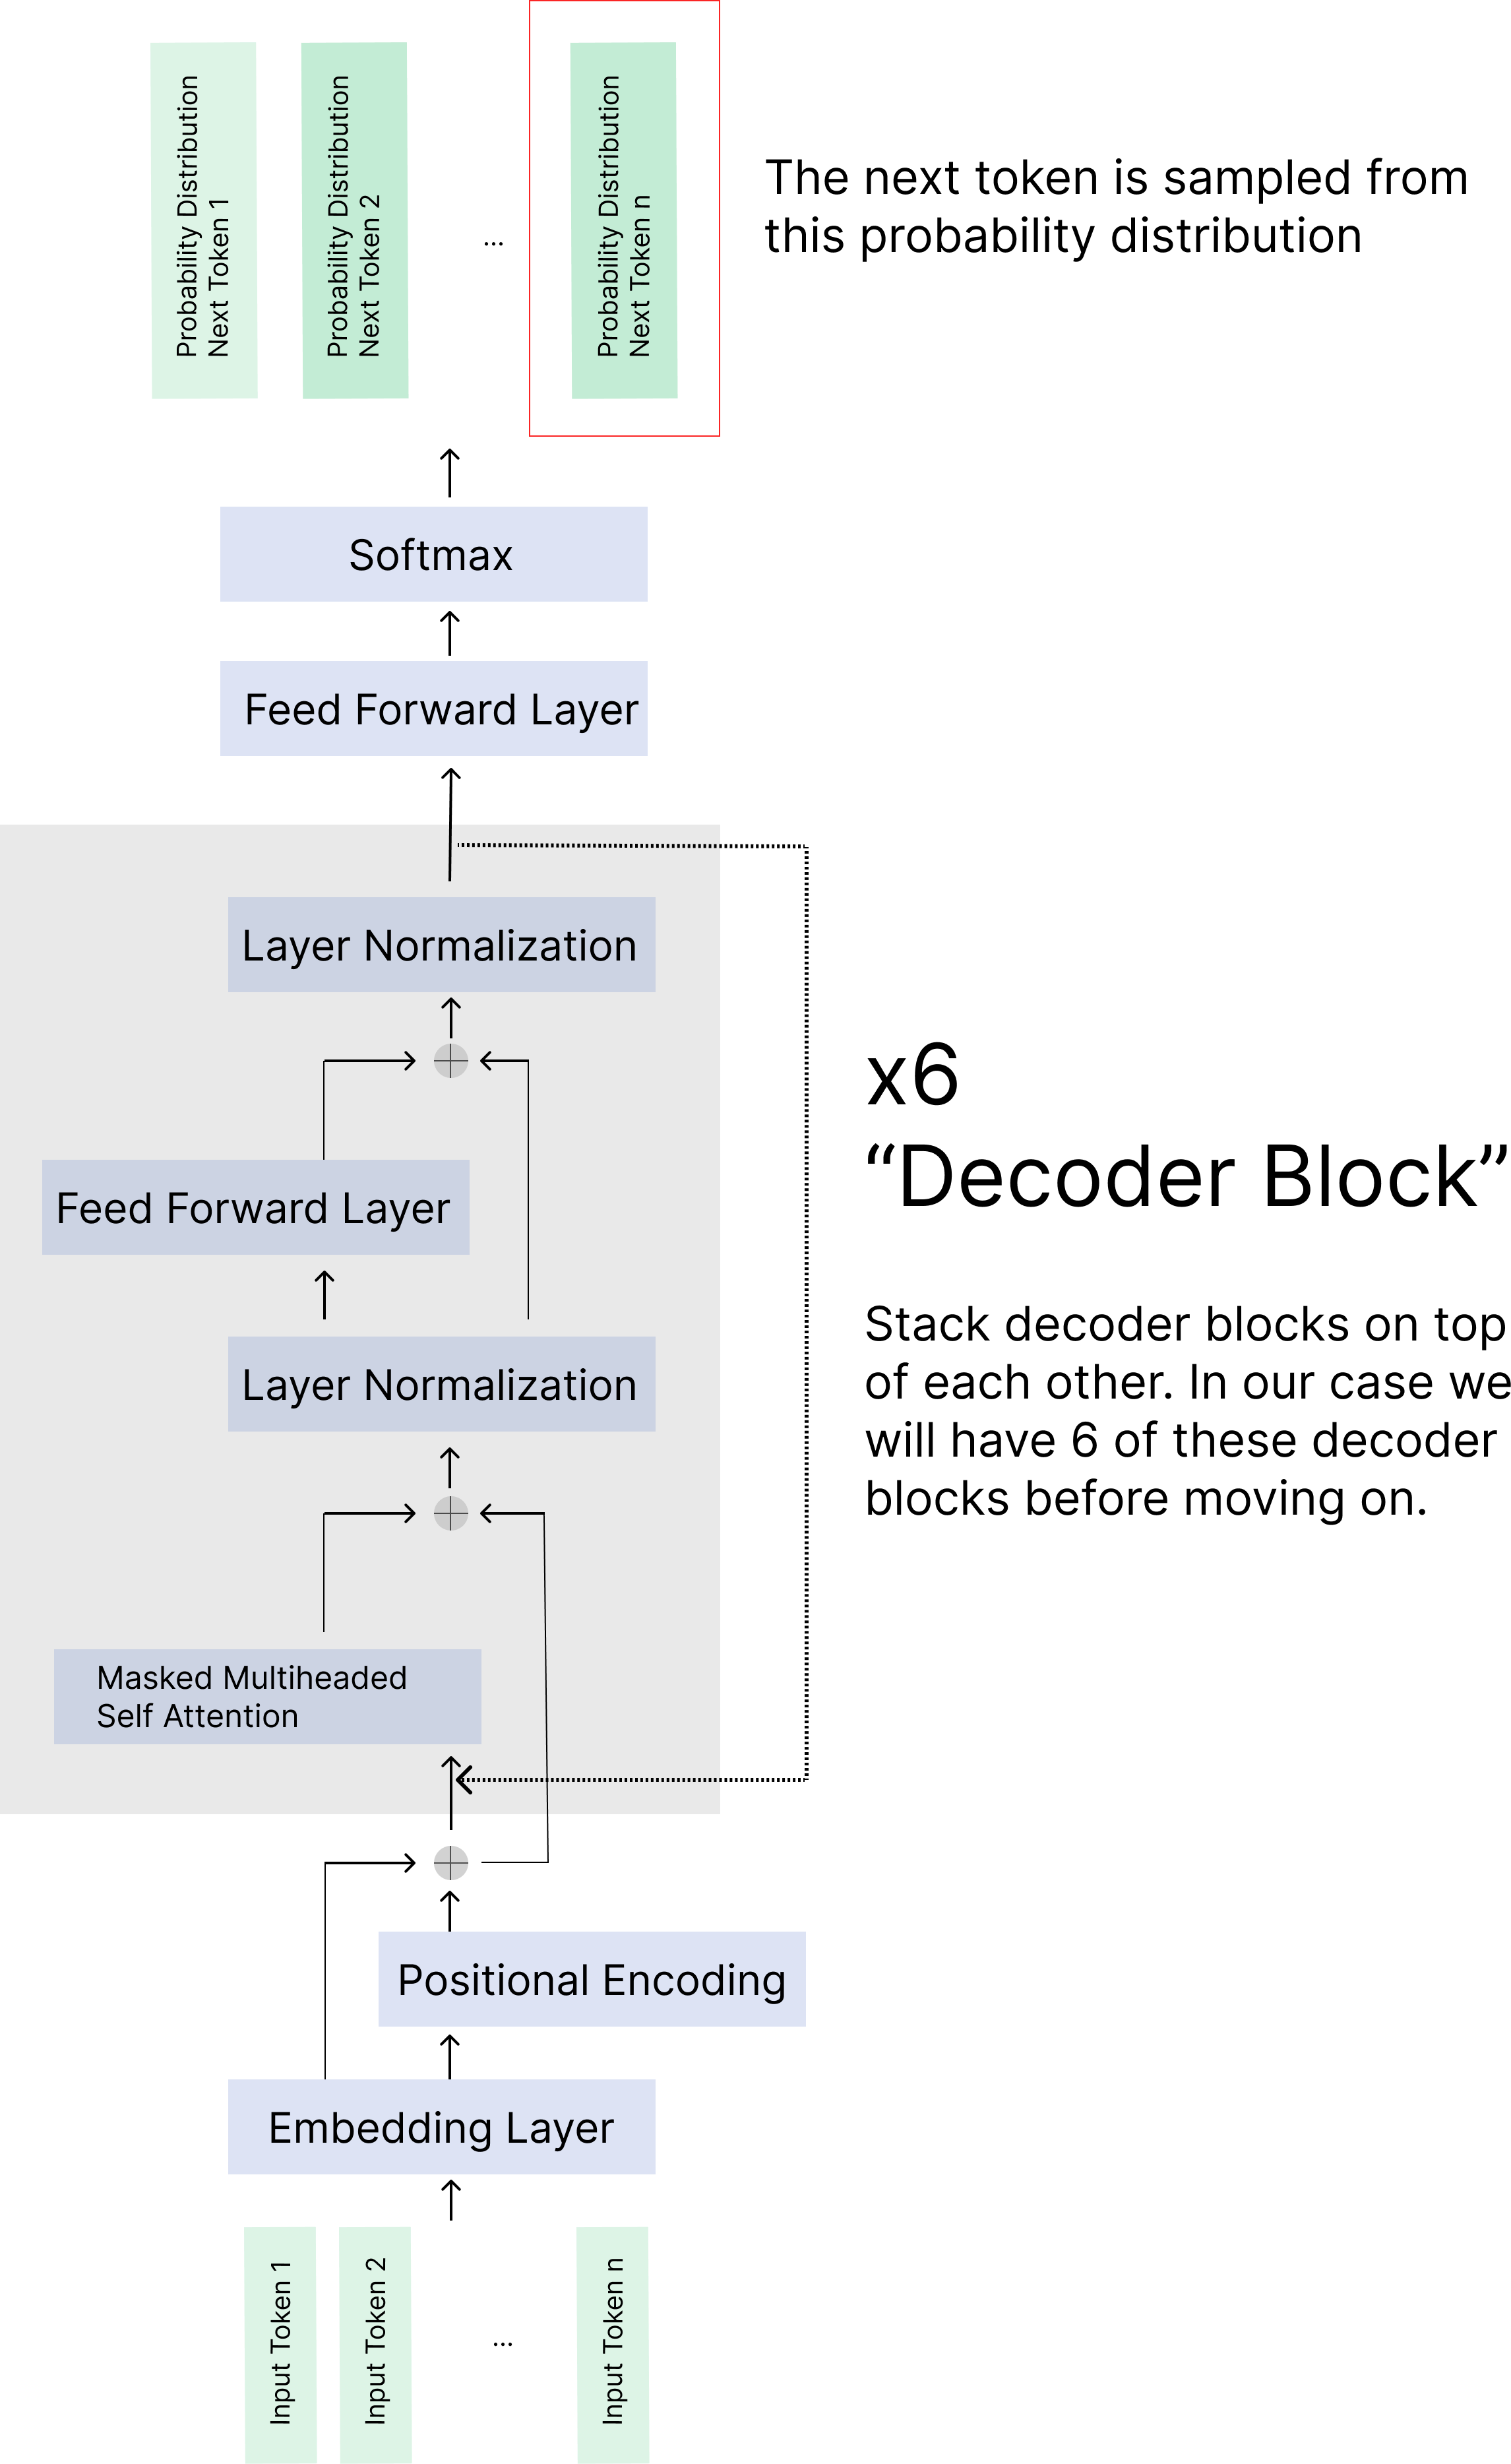

</div>

Эта архитектура напоминает оригинал. [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) модель, и очень похожа на [GPT2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) и [GPT3](https://arxiv.org/pdf/2005.14165), с тем основным отличием, что он меньше (меньше блоков декодера и меньший размер встраивания). В этой статье мы подробно рассмотрим каждый шаг этой диаграммы, чтобы обсудить математику, код и интуицию, лежащие в их основе.

Согласно оригинальной статье о GPT, существует два основных этапа обучения ранних моделей GPT: **pretraining** и **supervised fine tuning**. Предварительное обучение — это задача самоконтролируемого обучения, при которой часть входных данных опускается и используется в качестве целевых переменных. Самоконтролируемая точная настройка работает аналогично традиционным задачам контролируемого обучения, с аннотированными человеком метками для входных данных.    




# 1: Предварительная подготовка
Первым этапом построения модели GPT является предварительная подготовка. Предварительная подготовка создает «основу» LLM. Она позволяет модели понимать статистические свойства языка, грамматики и контекста. 

#### Цель предварительной подготовки

Цель предварительной подготовки проста: **создать модель, которая может надежно предсказывать следующий токен, исходя из предыдущих k токенов в последовательности**. Конечным результатом предварительной подготовки является модель глубокого обучения, которая принимает $k$ токенов и генерирует дискретное распределение вероятностей того, каким должен быть токен $k+1$. Мы хотим, чтобы это распределение показывало высокое значение для правильного токена и низкие значения для неправильных.

<div style="width:600px;margin:auto;">

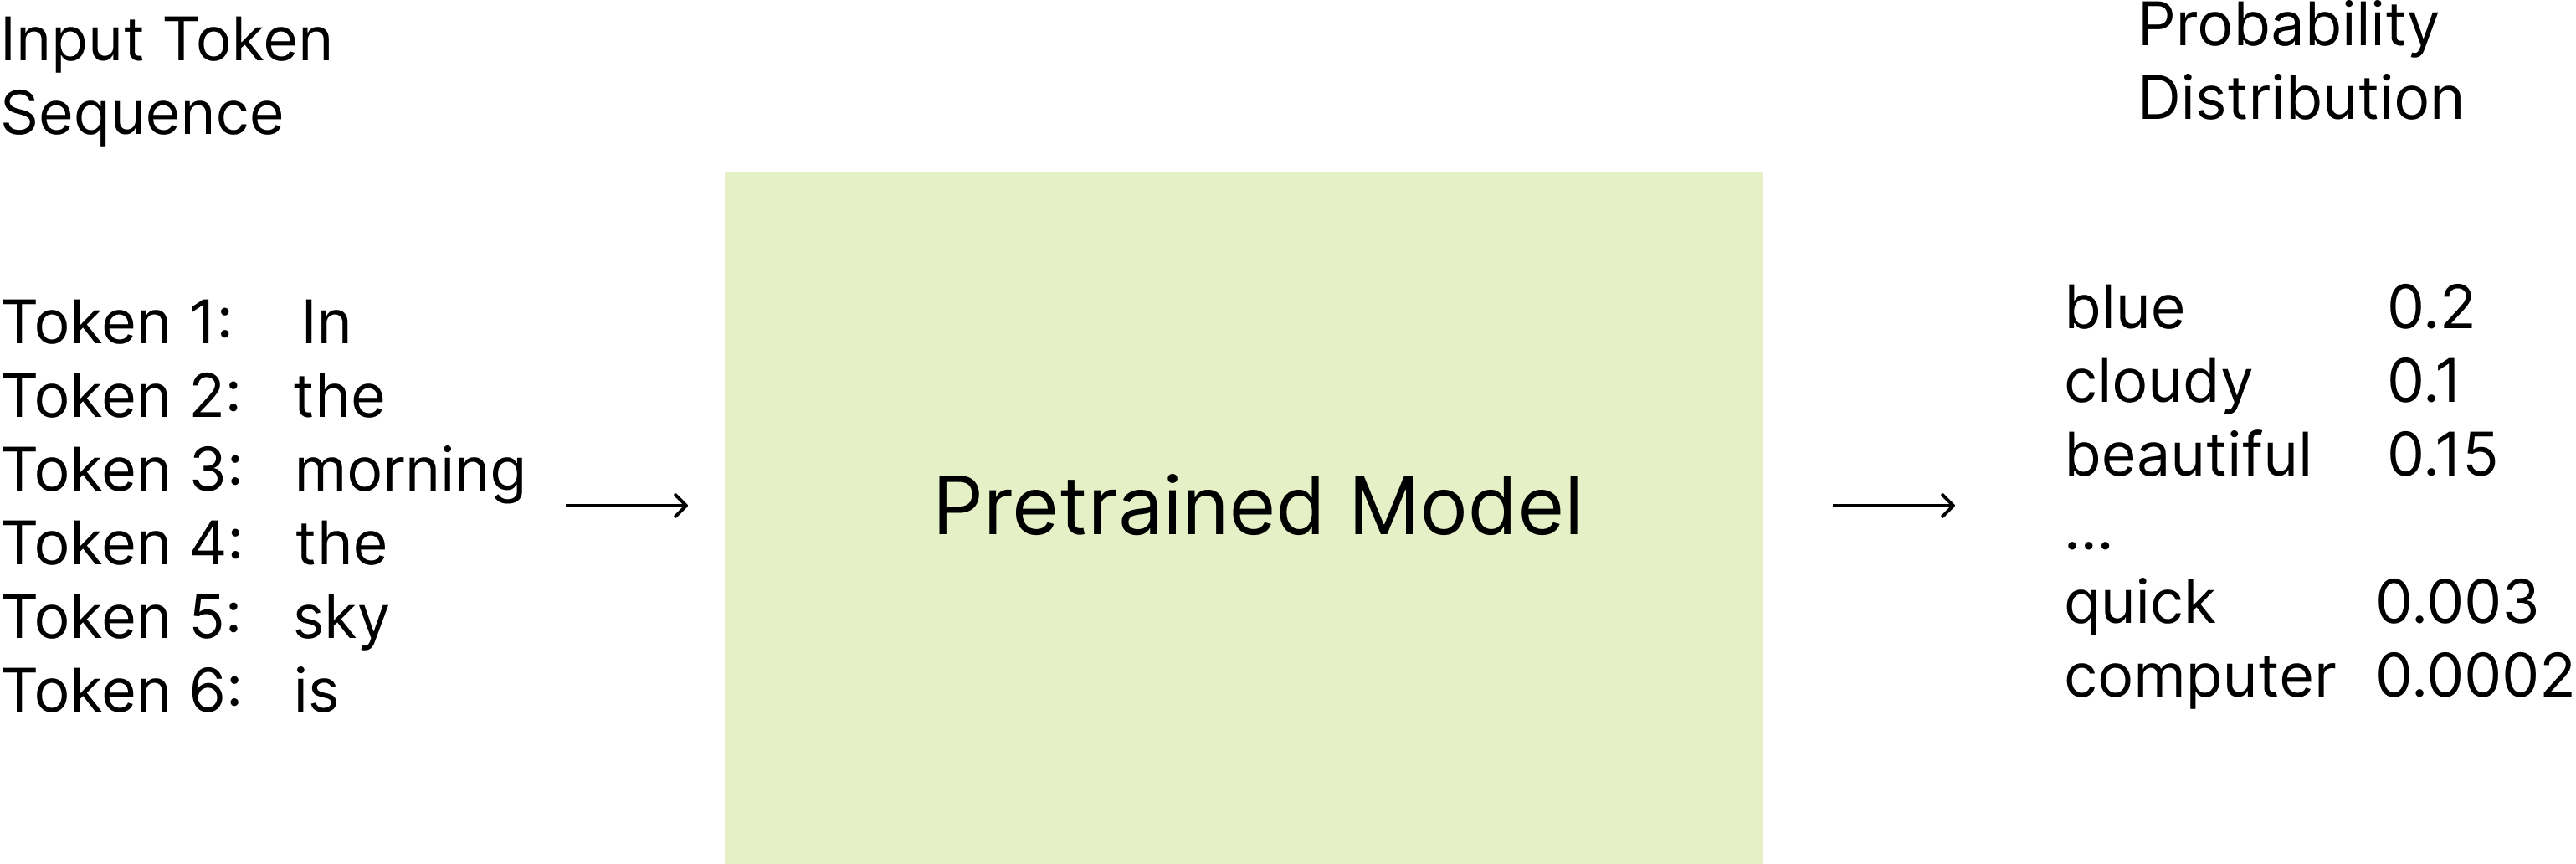 

</div>


Для этого мы начинаем с большого набора исходных текстов. Эти тексты могут быть взяты из книг, блогов, вики-сайтов, научных статей и других текстовых источников. После компиляции большого набора текстов мы разбиваем его на «куски» токенов, где каждый кусок содержит определенное количество токенов (512 gpt, 1024 gpt2, 16385 gpt-3). Размер этого фрагмента называется «контекстным окном». Предварительно обученная модель принимает столько токенов и выдает наиболее вероятный следующий токен.

#### Что такое токен?
При работе с LLM мы используем слово «токен» для описания наименьшей «единицы» текста, которую LLM может анализировать [5]. Токены можно в целом рассматривать как слова в концептуальном смысле. При анализе последовательности текста LLM сначала должен преобразовать текст в токены. Это похоже на поиск в словаре, где каждое слово/токен имеет целочисленный «индекс» в словаре. Именно этот индекс будет фактически вводиться в сеть для анализа.

<div style="width:600px;margin:auto;">

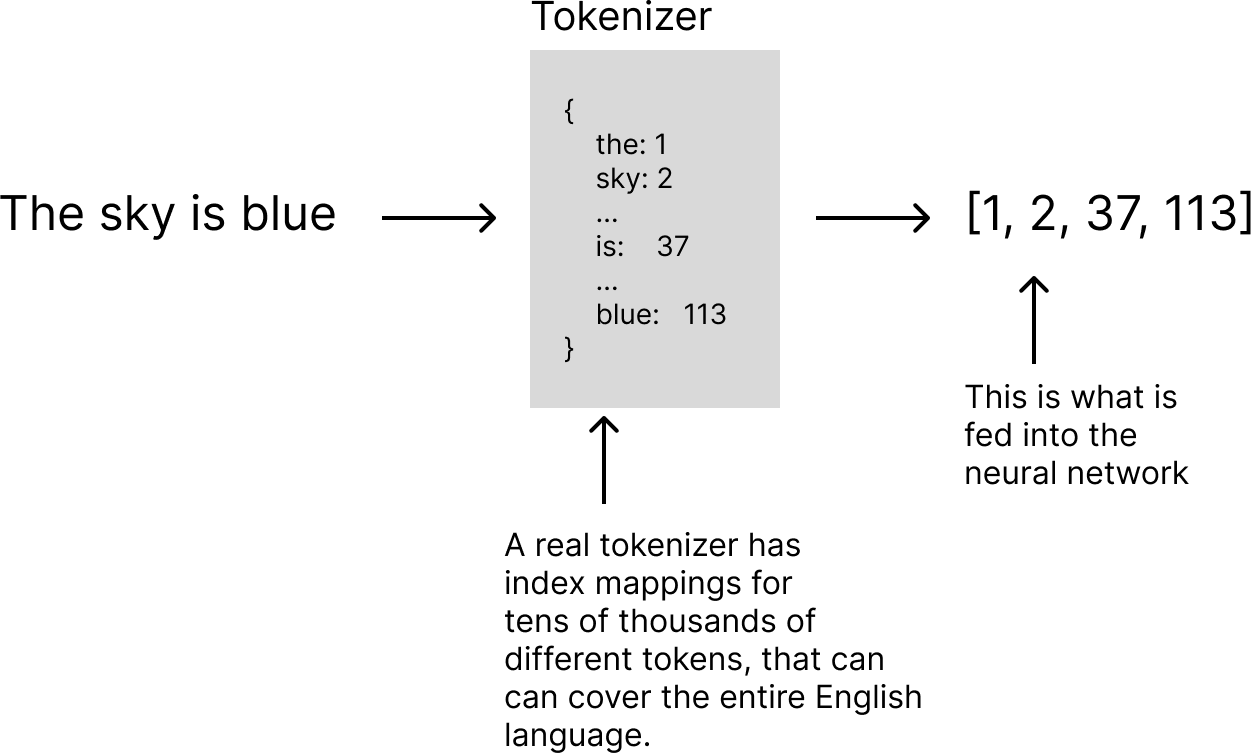

</div>

#### Формат данных предварительной подготовки
Каждый пример набора данных предварительной подготовки представляет собой фрагмент токенов. Один и тот же фрагмент токенов используется для ввода и вывода, но вывод сдвигается на 1 токен в «будущее». Причина этого связана с возможностями параллельной обработки трансформатора, которые мы подробно рассмотрим в разделе, посвященном трансформатору. Следующее изображение помогает понять, как выглядят данные для обучения модели предварительной подготовки.    

<div style="width:600px;margin:auto;">

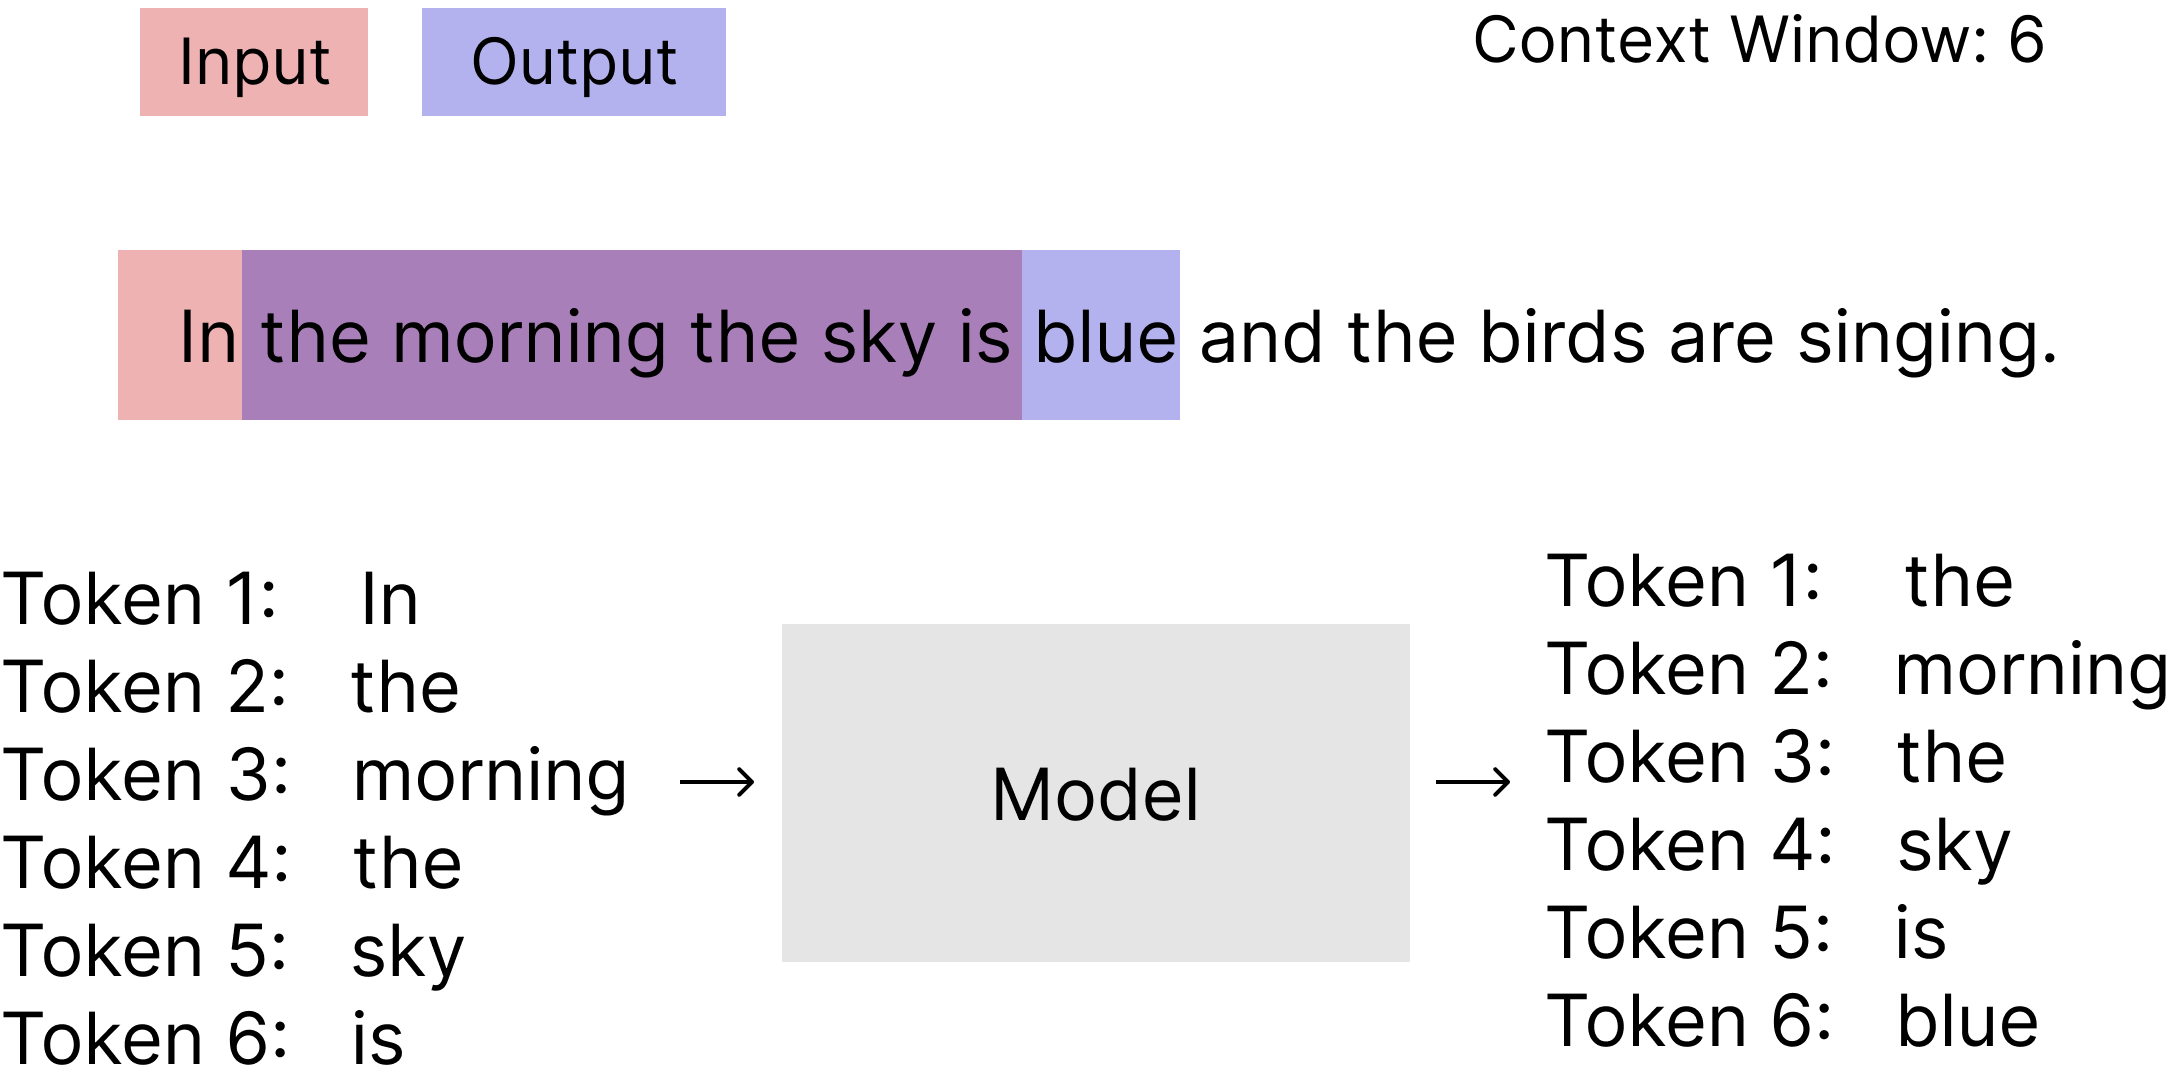   

</div>

Поскольку модель использует трансформаторы и параллельную обработку, один пример, подобный приведенному выше, на самом деле представляет собой 6 разных примеров. Модель изучает следующие прогнозируемые паттерны:
- Когда входные данные = in, выходные данные = the
- Когда входные данные = in the, выходные данные = morning
- Когда входные данные = in the morning, выходные данные = the
- Когда входные данные = in the morning the, выходные данные = sky
- Когда входные данные = in the morning the sky, выходные данные = is
- когда входные данные = утром, небо =, выходные данные = голубое

Это будет более понятно в разделе статьи, посвященном трансформаторам. Сейчас важно знать, каким должен быть формат входных и выходных данных на этапе предварительного обучения. Выходные данные — это входные данные, сдвинутые на один токен, так что каждый входной токен совпадает с выходным токеном, который идет непосредственно за ним в исходной последовательности.



## 1.1: Загрузка набора данных для предварительной подготовки

Перед выполнением полного цикла предварительной подготовки мы проведем «пробный запуск» с использованием небольшого набора данных, который помещается в памяти. Это позволит нам сосредоточиться на внутренней структуре модели, а не на сложностях обработки данных. Мы можем использовать набор данных [Salesforce wikitext](https://huggingface.co/datasets/EleutherAI/wikitext_document_level), который состоит из выдержек из хороших и популярных статей Википедии.   

Мы загрузим набор данных из [центра наборов данных huggingface](https://huggingface.co/docs/datasets/en/load_hub). Пакет huggingface datasets предоставляет простой способ загрузки, предварительной обработки и использования различных наборов данных для глубокого обучения.

In [ ]:
! pip install --upgrade datasets
! pip install tiktoken
! pip install transformers
! pip install torch
! pip install matplotlib

In [1]:
import warnings
import torch
import math
import time
import os
import matplotlib.pyplot as plt
from itertools import cycle
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from torch.optim.lr_scheduler import _LRScheduler
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from datasets import load_dataset
dataset = load_dataset("EleutherAI/wikitext_document_level", "wikitext-2-raw-v1", split="train")

## 1.2 Токенизация и разбиение на фрагменты набора данных

Для предварительной подготовки языковых моделей простой подход к токенизации и разбиению текста на фрагменты выглядит следующим образом:
1. Объедините весь текст в один гигантский «блок». Это означает, что у вас будет одна большая строка.
2. Токенизируйте весь блок в один список токенов. На этом этапе у вас будет один большой массив целых чисел.
3. Разбивайте токены на блоки фиксированного размера (1024, 2048, больше...) (это «контекстное окно»). На этом этапе у вас будет несколько массивов целых чисел, каждый из которых будет иметь одинаковую длину (размер контекста).


*Этот процесс немного изменится при использовании наборов данных, которые слишком велики, чтобы поместиться в памяти.*

### 1.2.1 Токенизация: использование Tiktoken

Один из простых способов токенизации нашего набора данных — использовать реализацию токенизатора OpenAI tiktoken для BPE (Byte Pair Encoding). В этой статье мы не будем подробно останавливаться на том, как работает реализация токенизатора, но просто отметим, что он преобразует текстовые строки в списки целых чисел, а также может преобразовывать списки целых чисел обратно в текстовые строки.

In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2") # Get the same tokenizer used for GPT-2


print("Vocabulary size:", tokenizer.n_vocab) # Vocabilary size is how many unique tokens the tokenizer can encode
print("End of text token:", tokenizer.eot_token) # End of text token is used to indicate the end of a text sequence
print("Example tokenization:", tokenizer.encode("Hello world!"))

# Convert entire dataset into a single string
# This dataset is small enough to fit into memory
# For larger datasets, you may need to use more 
# sophisticated methods to process the data.
all_text = ""
all_data = dataset["page"]
for example in all_data:
    all_text += "<page> "+ example + " </page>"

# Tokenize the entire text at once
tokenized_text = tokenizer.encode(all_text)


# We will create a function that generates a dataset of examples
# for the language model. The function will take in the number of
# examples to generate, the block size, and the test split.
# It will return the training and test datasets.
def get_dataset(num_examples, context_window_length, test_split=0.1):
    input_blocks = [] # List to store input sequences
    target_blocks = [] # List to store target sequences

    # Use a sliding window to create input/target sequences
    for i in range(0, len(tokenized_text), context_window_length + 1):
        block = tokenized_text[i:i+context_window_length+ 1]
        
        # Skip blocks that are too short
        if len(block) < context_window_length + 1:
            continue

        input_seq = block[:-1]  
        target_seq = block[1:]  

        input_blocks.append(input_seq)
        target_blocks.append(target_seq)
        
        # Stop if we have enough examples
        if len(input_blocks) >= num_examples:
            break

    # Convert to tensors for pytorch and move to gpu
    inputs = torch.tensor(input_blocks, dtype=torch.long).to(device)
    targets = torch.tensor(target_blocks, dtype=torch.long).to(device)

    # Calculate train/test split point
    split_idx = int(num_examples * (1 - test_split))

    # Split into train/test
    train_inputs = inputs[:split_idx]
    train_targets = targets[:split_idx]
    test_inputs = inputs[split_idx:]
    test_targets = targets[split_idx:]
    return train_inputs, train_targets, test_inputs, test_targets

# Get a small dataset
i, o, _, _ = get_dataset(2, 4, 0)
print("Input Shape", i.shape)
print("Output Shape", o.shape)
print("Input Example:")
print(i)
print("Output Example:")
print(o)


Vocabulary size: 50257
End of text token: 50256
Example tokenization: [15496, 995, 0]
Input Shape torch.Size([2, 4])
Output Shape torch.Size([2, 4])
Input Example:
tensor([[   27,  7700,    29,   220],
        [  569, 18354,  7496, 17740]], device='cuda:0')
Output Example:
tensor([[ 7700,    29,   220,   796],
        [18354,  7496, 17740,  6711]], device='cuda:0')


Используя наши методы токенизации, мы сгенерировали «фиктивный» набор данных, который будет использоваться в остальных диаграммах/примерах статьи для демонстрации форм матриц при их прохождении через модель.

- форма входа составляет $2x4$ - размер партии x токенов
- форма выхода составляет $2x4$ - размер партии x токенов    

Это означает, что у нас длина контекста составляет 4 токена, а размер партии — 2. Полный фиктивный набор данных содержит в общей сложности 2 примера. Это гораздо меньше, чем был бы набор данных в реальности, но полезно для представления архитектуры.

## 1.3 Создание LLM

Теперь, когда у нас есть небольшой фиктивный набор данных, мы можем создать архитектуру модели LLM в pytorch.

### 1.3.1 Объект Config
Сначала мы можем создать объект «config», который будет хранить наши параметры для сети. Позже мы подробно рассмотрим каждый параметр в сети.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# A simple configuration container
class GPTConfig:
    def __init__(
        self, 
        vocab_size,  # size of the vocabulary, from tokenizer, for gpt2 tokenizer it is 50257
        n_layer,   # number of transformer blocks
        n_head,    # number of attention heads for each transformer block
        n_embd,  # embedding dimension for each token
        seq_len,  # sequence length for the model - e.g. the "context window" 
    
    ):
        self.vocab_size = vocab_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.seq_len = seq_len
     
test_config = GPTConfig(
    vocab_size=tokenizer.n_vocab,
    n_layer=2,  
    n_head=3,
    n_embd=6,
    seq_len=4,
)

### 1.3.2 Token Embedding Layer

<div style="width:400px;margin:auto;">

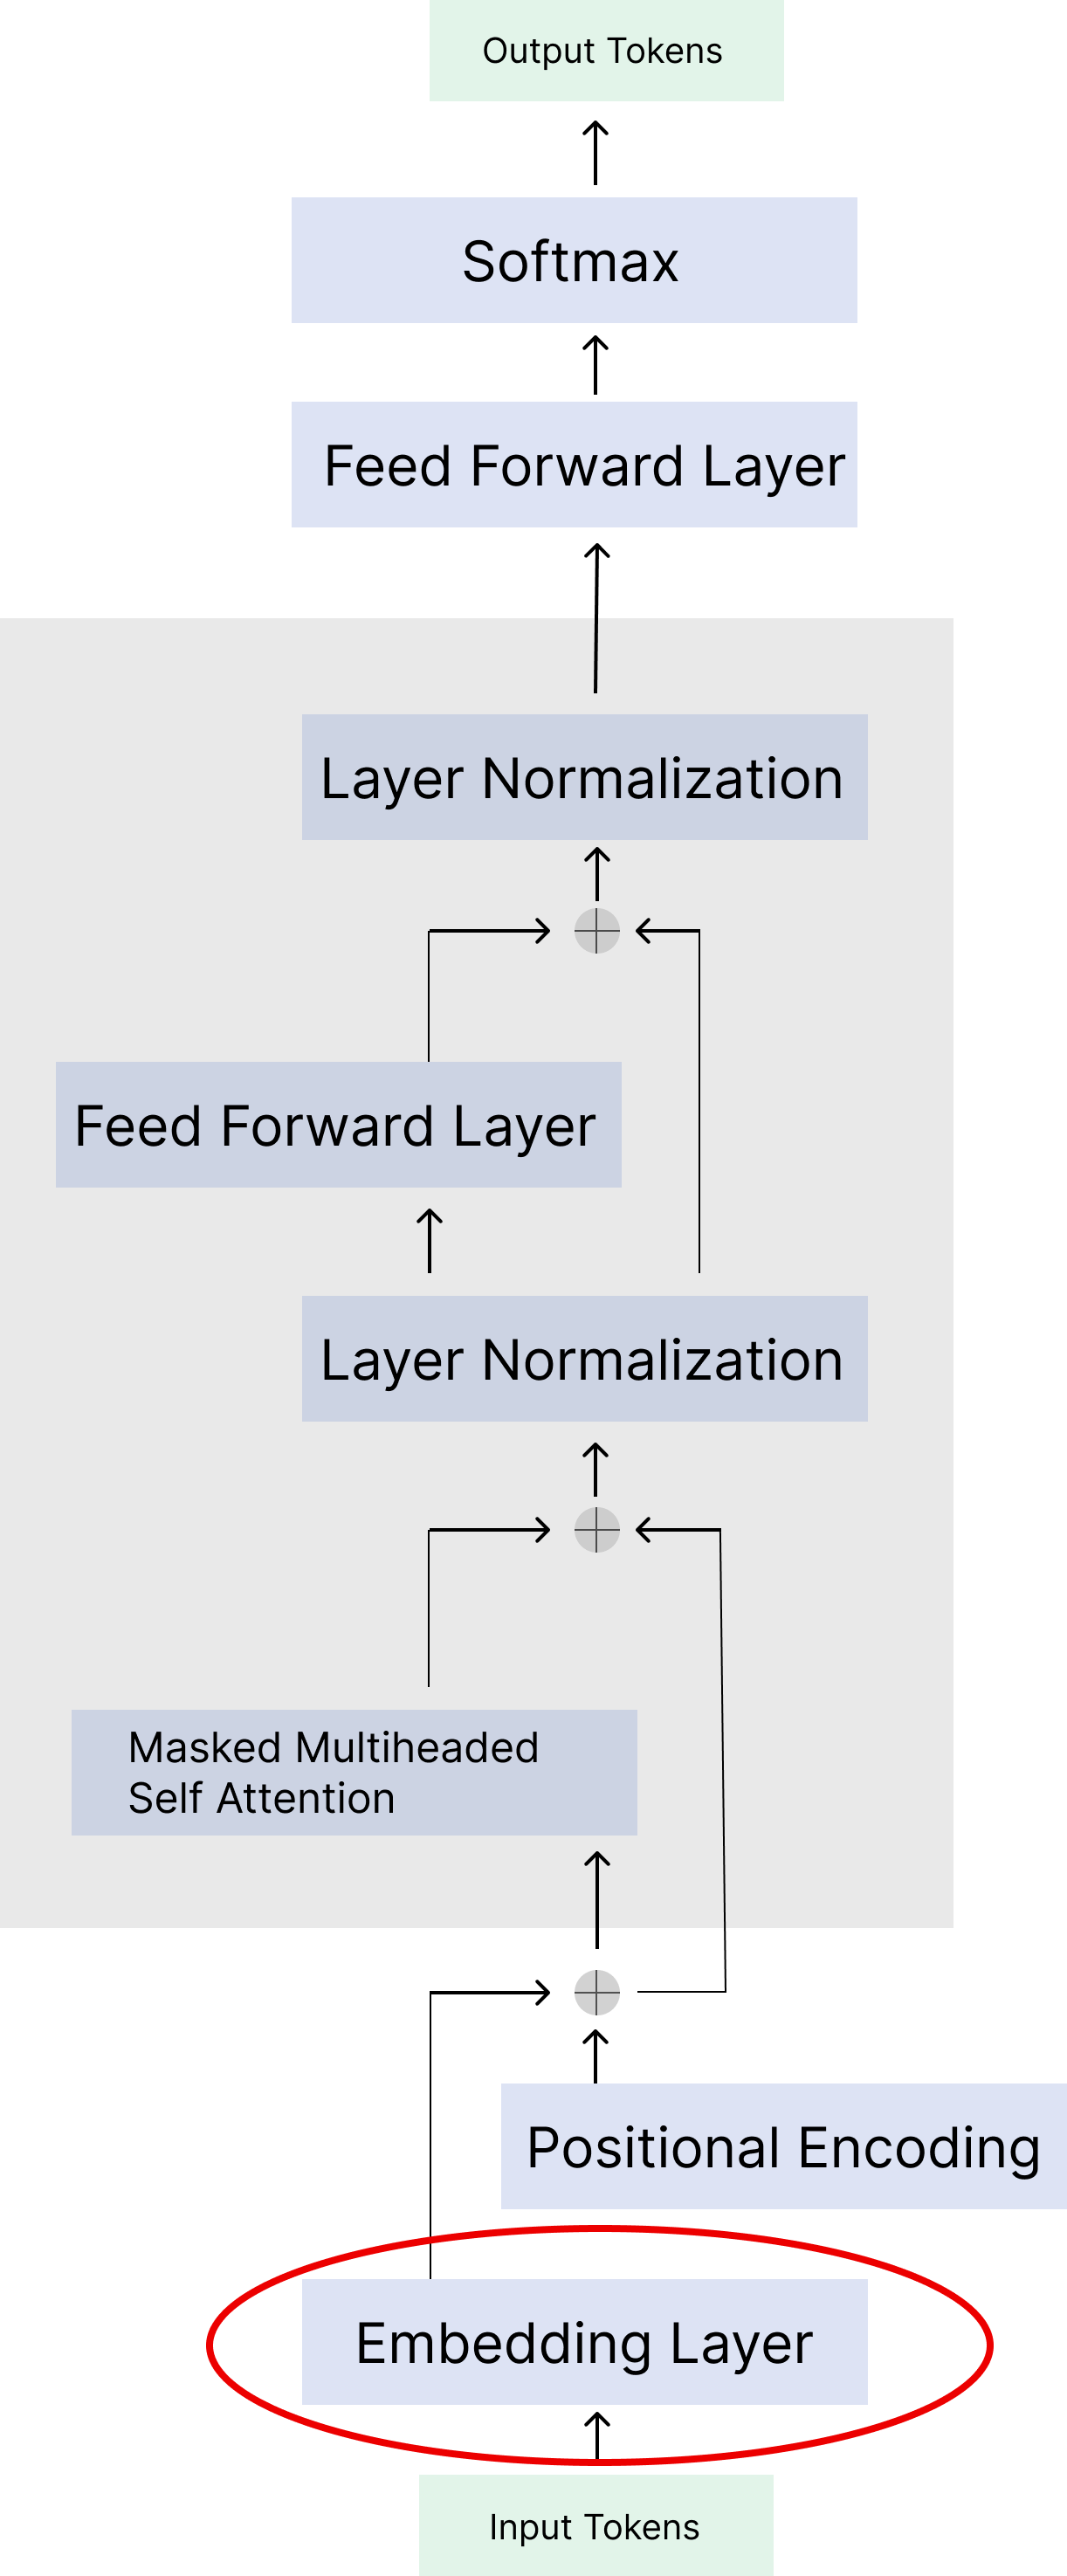

</div>

Первым слоем нашей сети будет **слой встраивания токенов**. Этот слой немного отличается от традиционных слоев нейронной сети. По сути, это таблица поиска, которая возвращает «вектор встраивания» для заданного целочисленного индекса. **Цель этого слоя — преобразовать токены в векторы**. Эти векторы настраиваются по мере обучения сети, чтобы их положение в пространстве относительно других токенов отражало их статистические взаимосвязи друг с другом.    

Слой встраивания преобразует дискретный токен (целое число) в семантическое представление этого токена (вектор). До слоя встраивания модель не имеет представления о том, что означает токен и как он соотносится с другими токенами. После слоя встраивания модель понимает семантическое значение токена по его взаимосвязи с другими токенами в пространстве встраивания. Для получения дополнительной информации о вложениях слов см. статью [Word2Vec](https://arxiv.org/pdf/1301.3781) [13]. 

Это векторы, которые вначале являются случайными, но постепенно принимают значения в пространстве вложения, которые отражают семантическое значение токена. Этот процесс происходит во время обучения.

<div style="width:800px;margin:auto;">

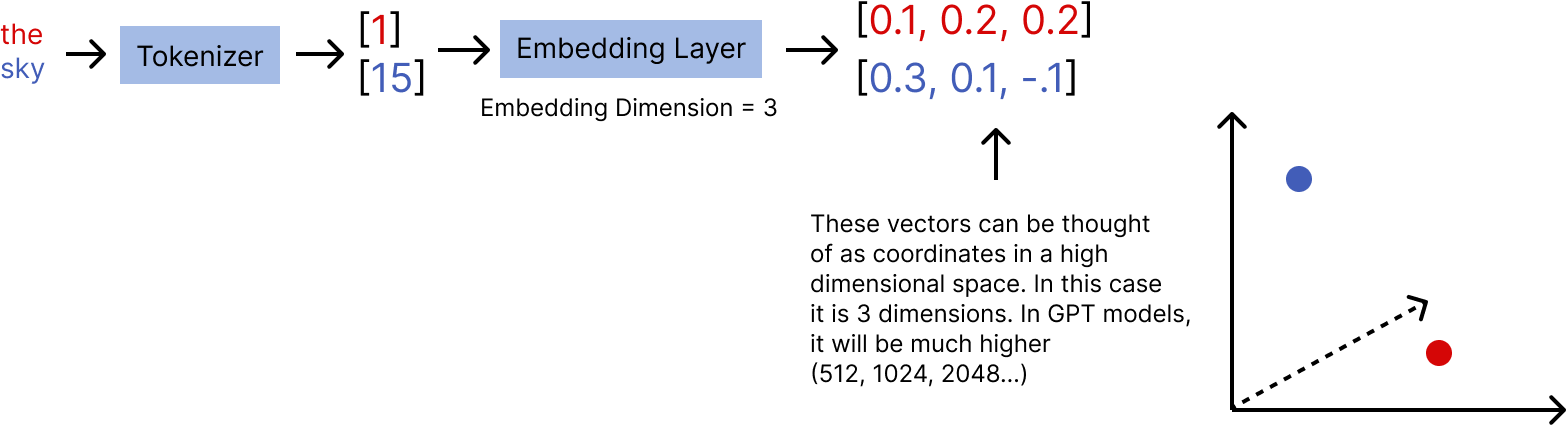

</div>


Для нашего фиктивного набора данных входными данными для этого слоя будет матрица размером $2x4$, пакет x индексы токенов. Выходными данными будет матрица размером $2x4x6$, пакет x токены x размеры вложения. Это преобразование можно визуализировать следующим образом:

<div style="width:600px;margin:auto;">

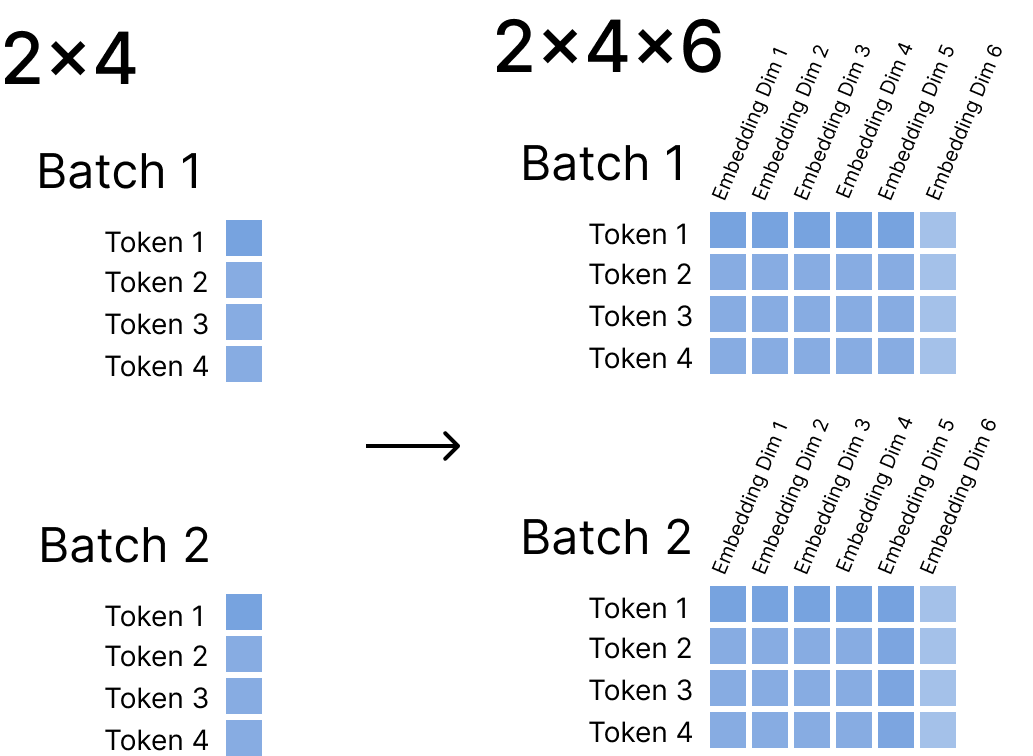

</div>

In [5]:
token_embedding = nn.Embedding(test_config.vocab_size, test_config.n_embd).to(device)
test_batch_inputs, _, _, _ = get_dataset(2, test_config.seq_len, 0)
print("Batch shape:", test_batch_inputs.shape, "Batch x Seq Len")
print("After embedding:", token_embedding(test_batch_inputs).shape, "Batch x Seq Len x Embedding Dim")
print("")
print("Before embedding")
print(test_batch_inputs)
print("After embedding")
print(token_embedding(test_batch_inputs))

Batch shape: torch.Size([2, 4]) Batch x Seq Len
After embedding: torch.Size([2, 4, 6]) Batch x Seq Len x Embedding Dim

Before embedding
tensor([[   27,  7700,    29,   220],
        [  569, 18354,  7496, 17740]], device='cuda:0')
After embedding
tensor([[[-0.0850, -0.5393, -0.4814, -0.5201,  0.8528,  1.5614],
         [ 1.7124,  0.9409,  0.5425, -0.2307,  1.0325,  0.6966],
         [ 1.8344, -0.6808,  0.1047,  0.9956,  0.6336,  0.1757],
         [-0.3960, -1.9960, -0.7287,  0.4127,  0.1946, -0.3331]],

        [[ 2.4173, -1.0166,  0.2398, -0.3766, -0.5538,  0.2580],
         [-1.2367, -0.7099, -0.0859, -0.8818, -0.9876,  0.7716],
         [ 1.1070, -0.5770,  0.2477,  2.5843,  0.5314,  1.3516],
         [ 1.0932, -0.0932, -1.0295,  0.9911, -0.2331,  2.5532]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)


В этом примере мы используем размер вложения 6, поэтому каждый исходный токен сопоставляется с вектором длины 6. На данный момент эти векторы не имеют никакого реального значения, они инициализированы случайным образом. Однако в процессе обучения эти записи будут постепенно изменяться с помощью обратного распространения, и со временем они начнут приобретать значение для соответствующих токенов.

### 1.3.3 Positional Encoding Layer

<div style="width:400px;margin:auto;">

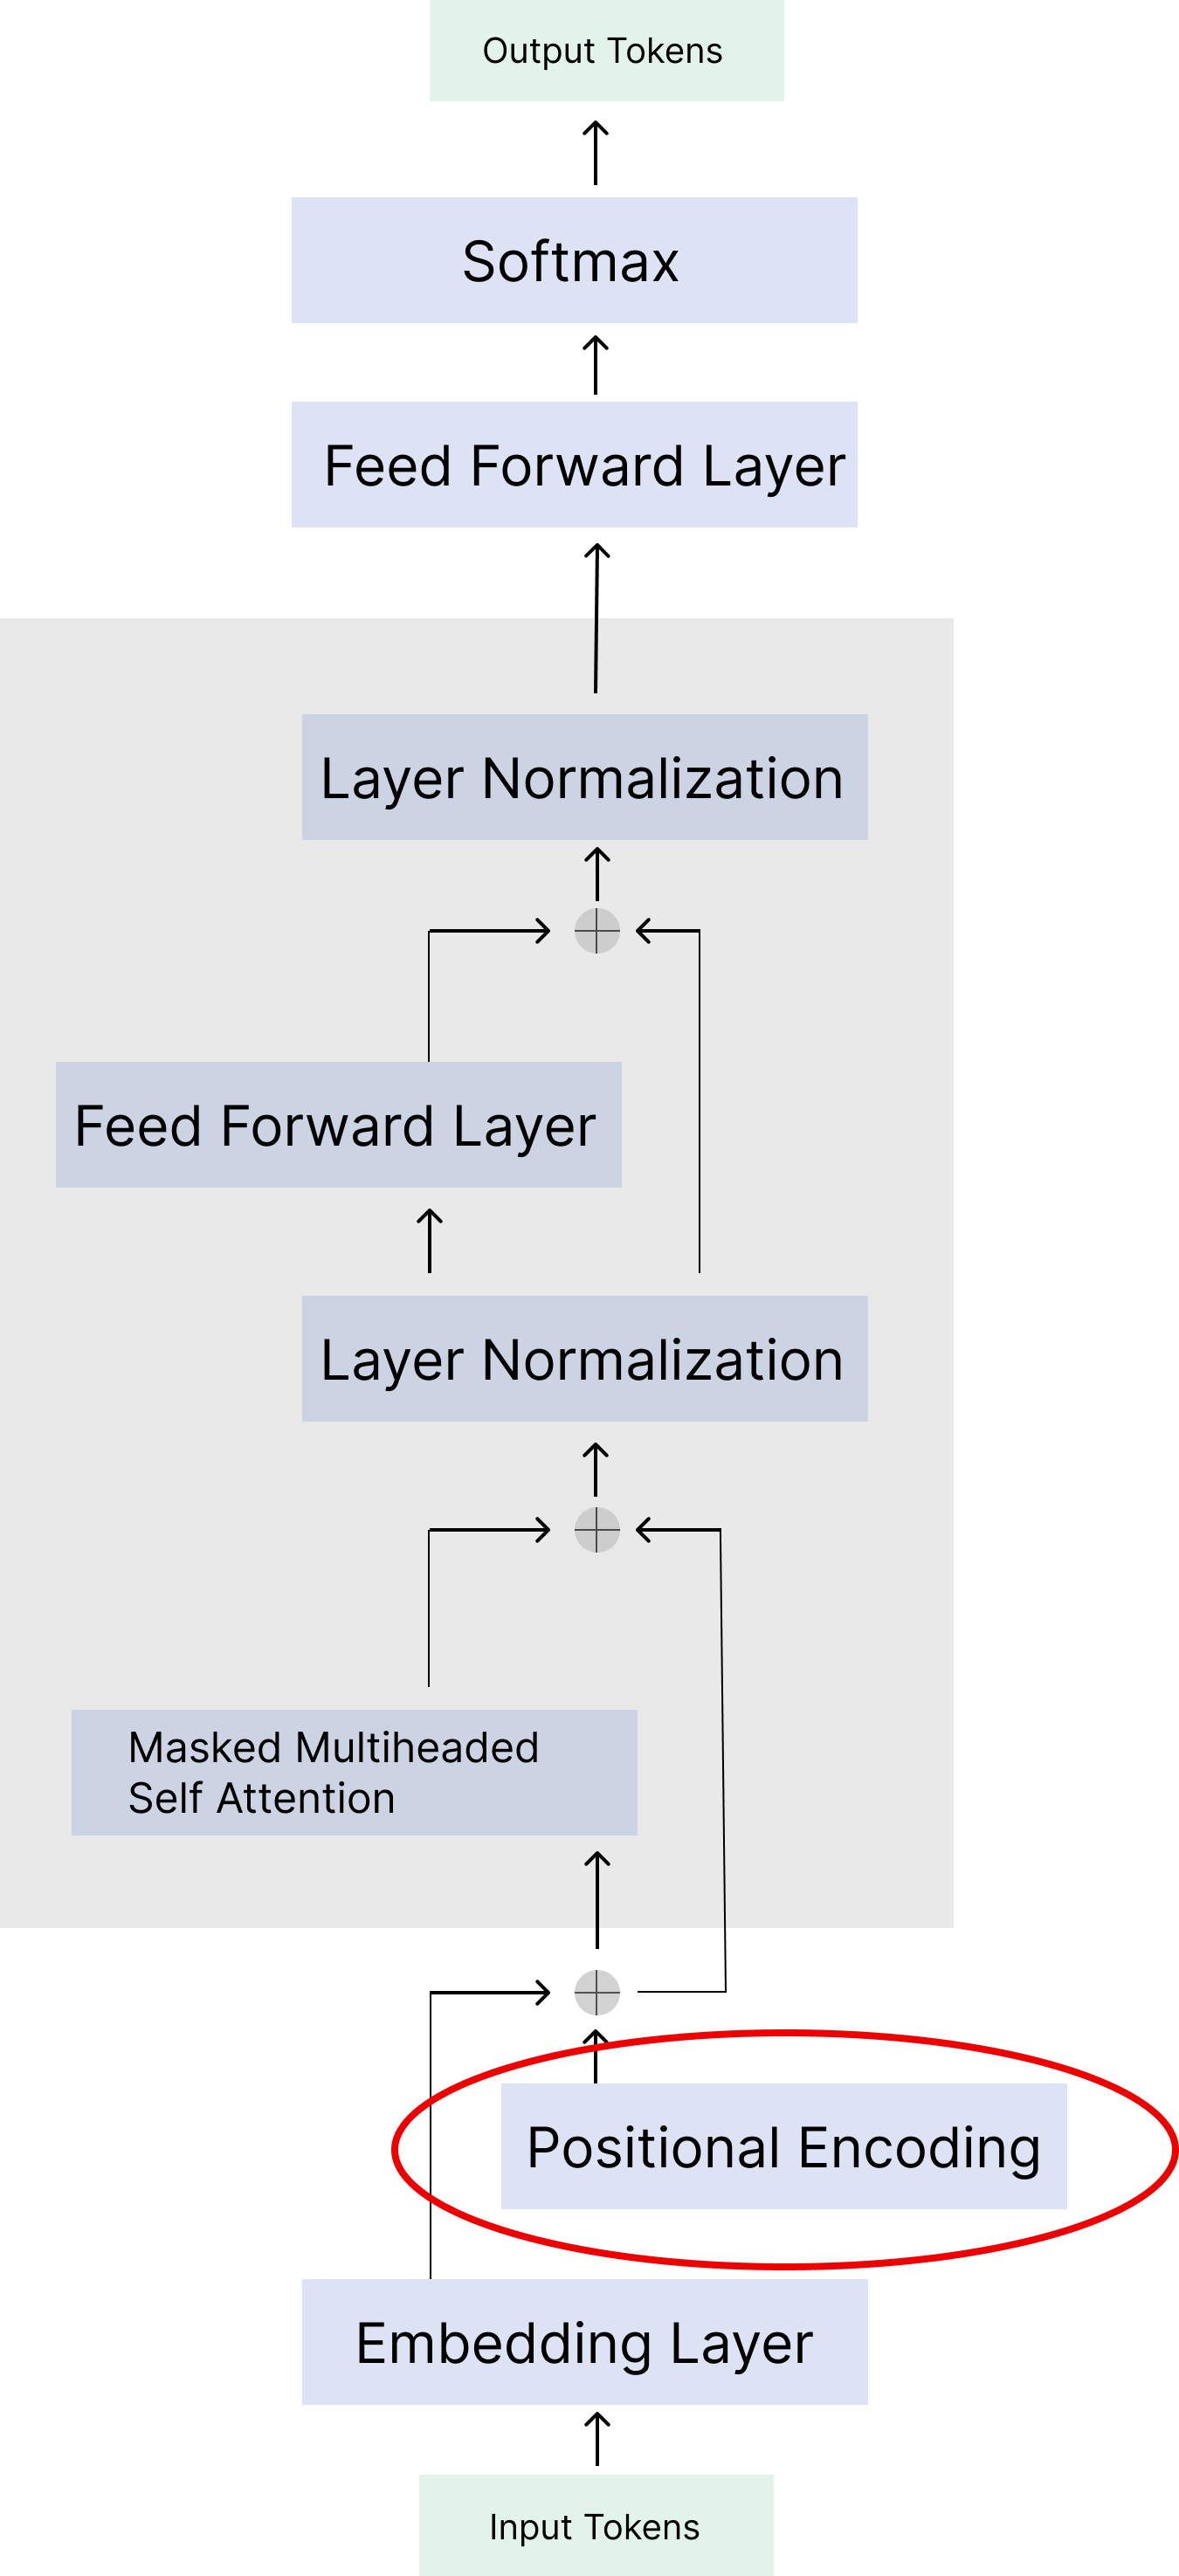

</div>

После встраивания токенов в векторы встраивания мы добавим к векторам позиционное кодирование. Зачем нам нужно позиционное кодирование? Рассмотрим следующее предложение:

*Эта планета меньше другой планеты.*

Позиционное кодирование позволяет модели различать два случая использования слова «планета». Без позиционного кодирования два вектора встраивания токенов для каждого случая использования слова «планета» были бы абсолютно одинаковыми. Наличие позиционного кодирования позволяет модели различать два случая использования в одном и том же предложении.

Мы будем использовать формулу позиционного кодирования, которая была использована в оригинальной статье о трансформере [9]. Формула работает, начиная с матрицы формы «длина последовательности x размер вложения». Затем матрица заполняется следующей формулой:

$$PE(POS,2i) = sin(\frac{pos}{10000^\frac{2i}{d}})$$
$$PE(POS,2i+1) = cos(\frac{pos}{10000^\frac{2i}{d}})$$

Где $POS$ — положение токена в последовательности, i — индекс вложенного измерения в токене, а d — размер вложенного измерения модели. Вся эта формула выдает матрицу, которая зависит от размера вложения. Результирующая матрица будет иметь размер (seq_length x размер вложения). Матрица начинается со всех нулей, а затем применяется формула.

In [6]:
def get_position_encoding(seq_len, d, n=10000):
    """
    Computes the positional encoding matrix of shape (seq_len, d).
    
    Args:
        seq_len (int): Length of the sequence.
        d (int): Dimension of the embedding.
        n (float): The base for the exponential term (default 10000 in many Transformer implementations).
    
    Returns:
        torch.Tensor: A tensor of shape (seq_len, d) containing the positional encodings.
    """
    
    P = torch.zeros(seq_len, d).to(device)
    for pos in range(seq_len):
        for i in range(0, d // 2):
            P[pos, 2 * i] = math.sin(pos / (n ** ((2 * i) / d)))
            if i + 1 < d:
                P[pos, 2* i + 1] = math.cos(pos / (n ** ((2 * i) / d)))

    return P.unsqueeze(0)


# Example usage:
position_encoding = get_position_encoding(seq_len=test_config.seq_len, d=test_config.n_embd)
print("Position encoding shape:", position_encoding.shape)


Position encoding shape: torch.Size([1, 4, 6])


После получения позиционного кодирования мы добавляем его с помощью элементарного сложения к векторам вложения. Поскольку мы используем pytorch, сложение будет «транслироваться» по первому измерению. Это означает, что матрица позиционного кодирования 4x6 будет добавляться к каждому примерам партии параллельно.   

<div style="width:800px;margin:auto;">

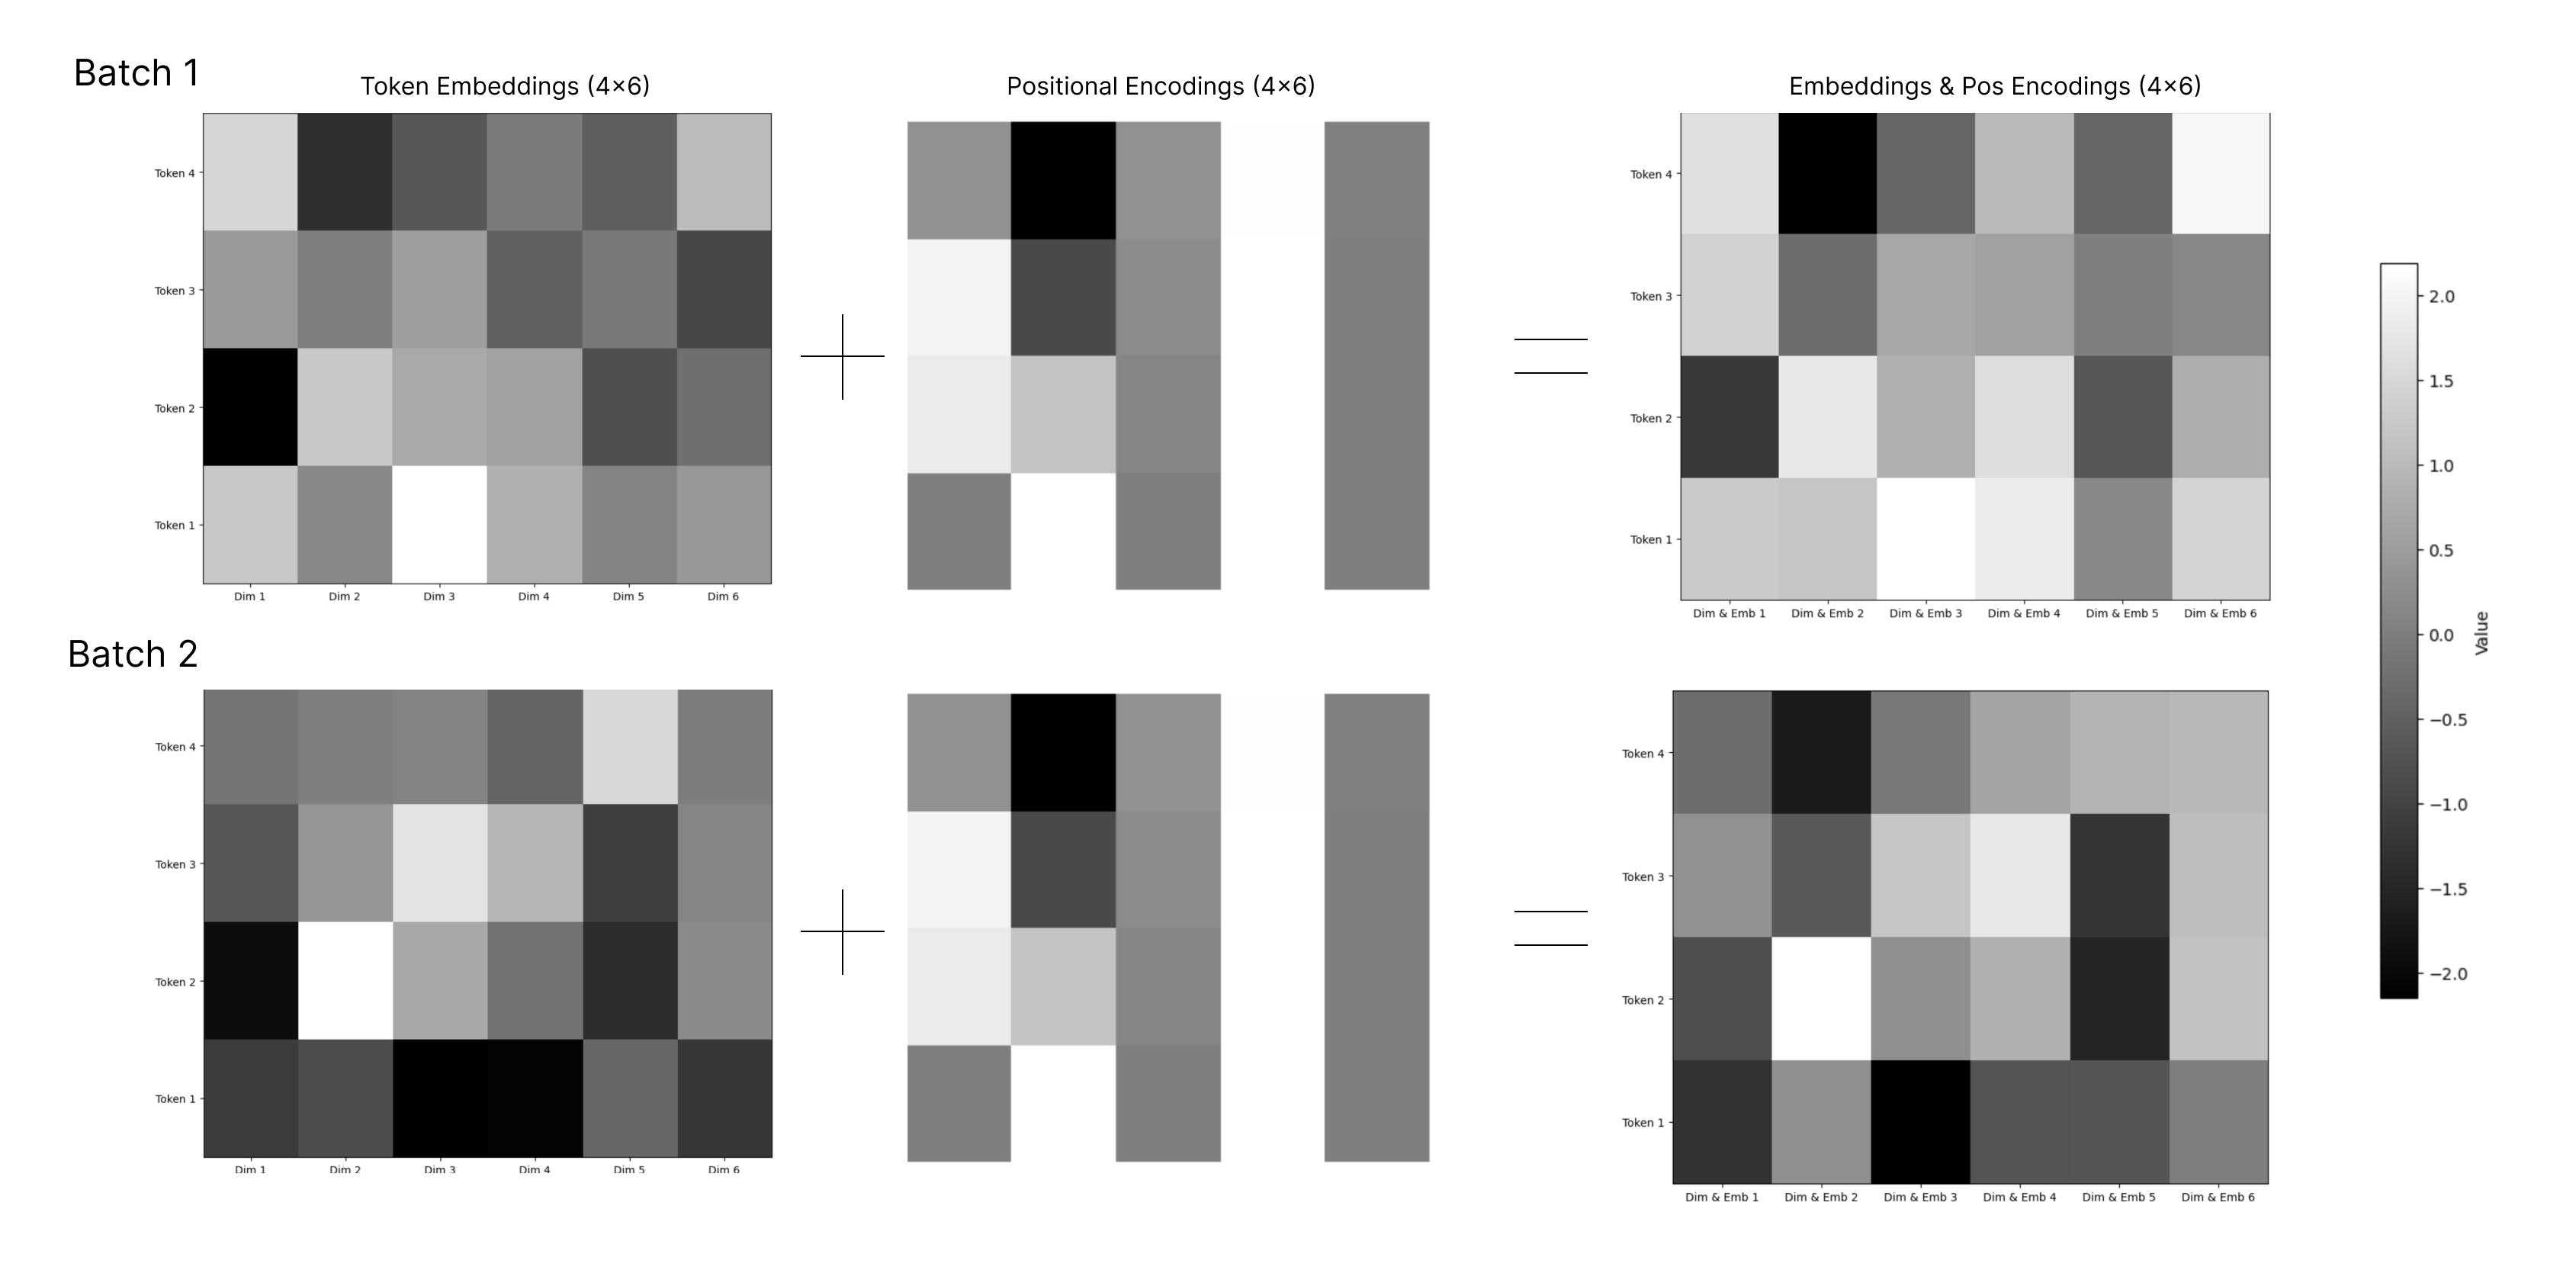

</div>

In [7]:
test_embeddings = token_embedding(test_batch_inputs)
test_embeddings_with_pos = test_embeddings + position_encoding
print("Token embeddings shape:", test_embeddings.shape)
print("Position encodings shape:", position_encoding.shape)
print("Sum of token embeddings and position encodings:",test_embeddings_with_pos.shape)


Token embeddings shape: torch.Size([2, 4, 6])
Position encodings shape: torch.Size([1, 4, 6])
Sum of token embeddings and position encodings: torch.Size([2, 4, 6])


#### Что лежит в основе позиционного кодирования?

Сначала может быть сложно понять, как работает позиционное кодирование. Позиционное кодирование — это просто постоянная матрица (учитывая длину последовательности и размер вложения), значения которой установлены в соответствии с желаемым шаблоном. Каждая строка матрицы соответствует токену, что означает, что каждый раз к токену в позиции 1 будет добавлен постоянный вектор, а к токену в позиции 2 — другой постоянный вектор и т. д.

Это различает значение слова «планета», стоящего в начале предложения, и значение того же слова, стоящего в конце предложения. Однако иногда относительное положение слов в предложении важнее абсолютного. Как же учесть это? Ответ заключается в том, что относительные отношения между словами являются эмерджентными. Они возникают в процессе внимания, о котором мы поговорим позже.

Ключевым моментом здесь является то, что без позиционного кодирования эти два предложения выглядели бы одинаково:
- Собака гналась за хозяином
- Хозяин гнался за собакой


Позиционное кодирование делает векторы для собаки и хозяина разными в двух предложениях, что позволяет вниманию уловить относительные отношения между этими двумя словами.

На изображении ниже показан пример матрицы позиционного кодирования. Выглядит интересно, но что именно мы видим? Почему это помогает модели кодировать положение каждого вектора вложения? Помните, что каждая строка в нашем векторе вложения представляет слово/токен. Мы добавим эту матрицу к матрице вложения, чтобы кодировать положения. Одно из замечаний по поводу этой матрицы заключается в том, что каждая строка уникальна. Между каждой строкой также есть плавный переход. Если взять строки 27 и 28 из этой матрицы, они будут иметь очень похожие паттерны. Однако если взять строки 1 и 120 из этой матрицы, они будут отличаться гораздо больше. Эта плавность также является важной особенностью, которая помогает модели понимать позицию [10].

<div style="width:500px;margin:auto;">

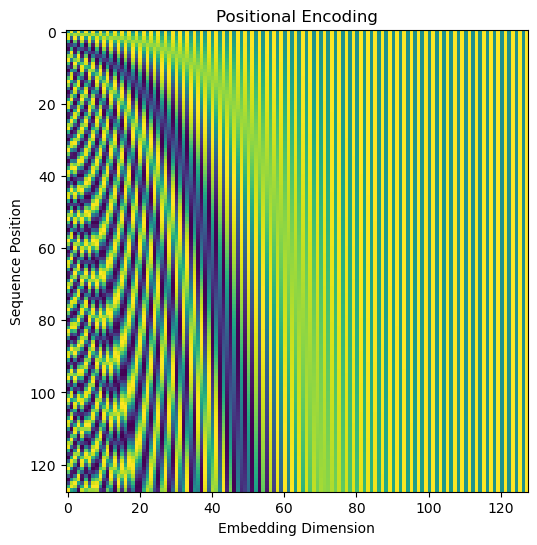

</div>

В приведенной выше формуле нет ничего особенного, существуют и другие формулы для позиционного кодирования. Главное, что нужно отметить, это то, что должна быть некая матрица, которую мы можем добавить к нашей матрице вложения, которая кодирует позицию. Эта формула имеет определенные свойства, которые облегчают модели выполнение этой задачи.   


### 1.3.4 Masked Multiheaded Self Attention

<div style="width:400px;margin:auto;">

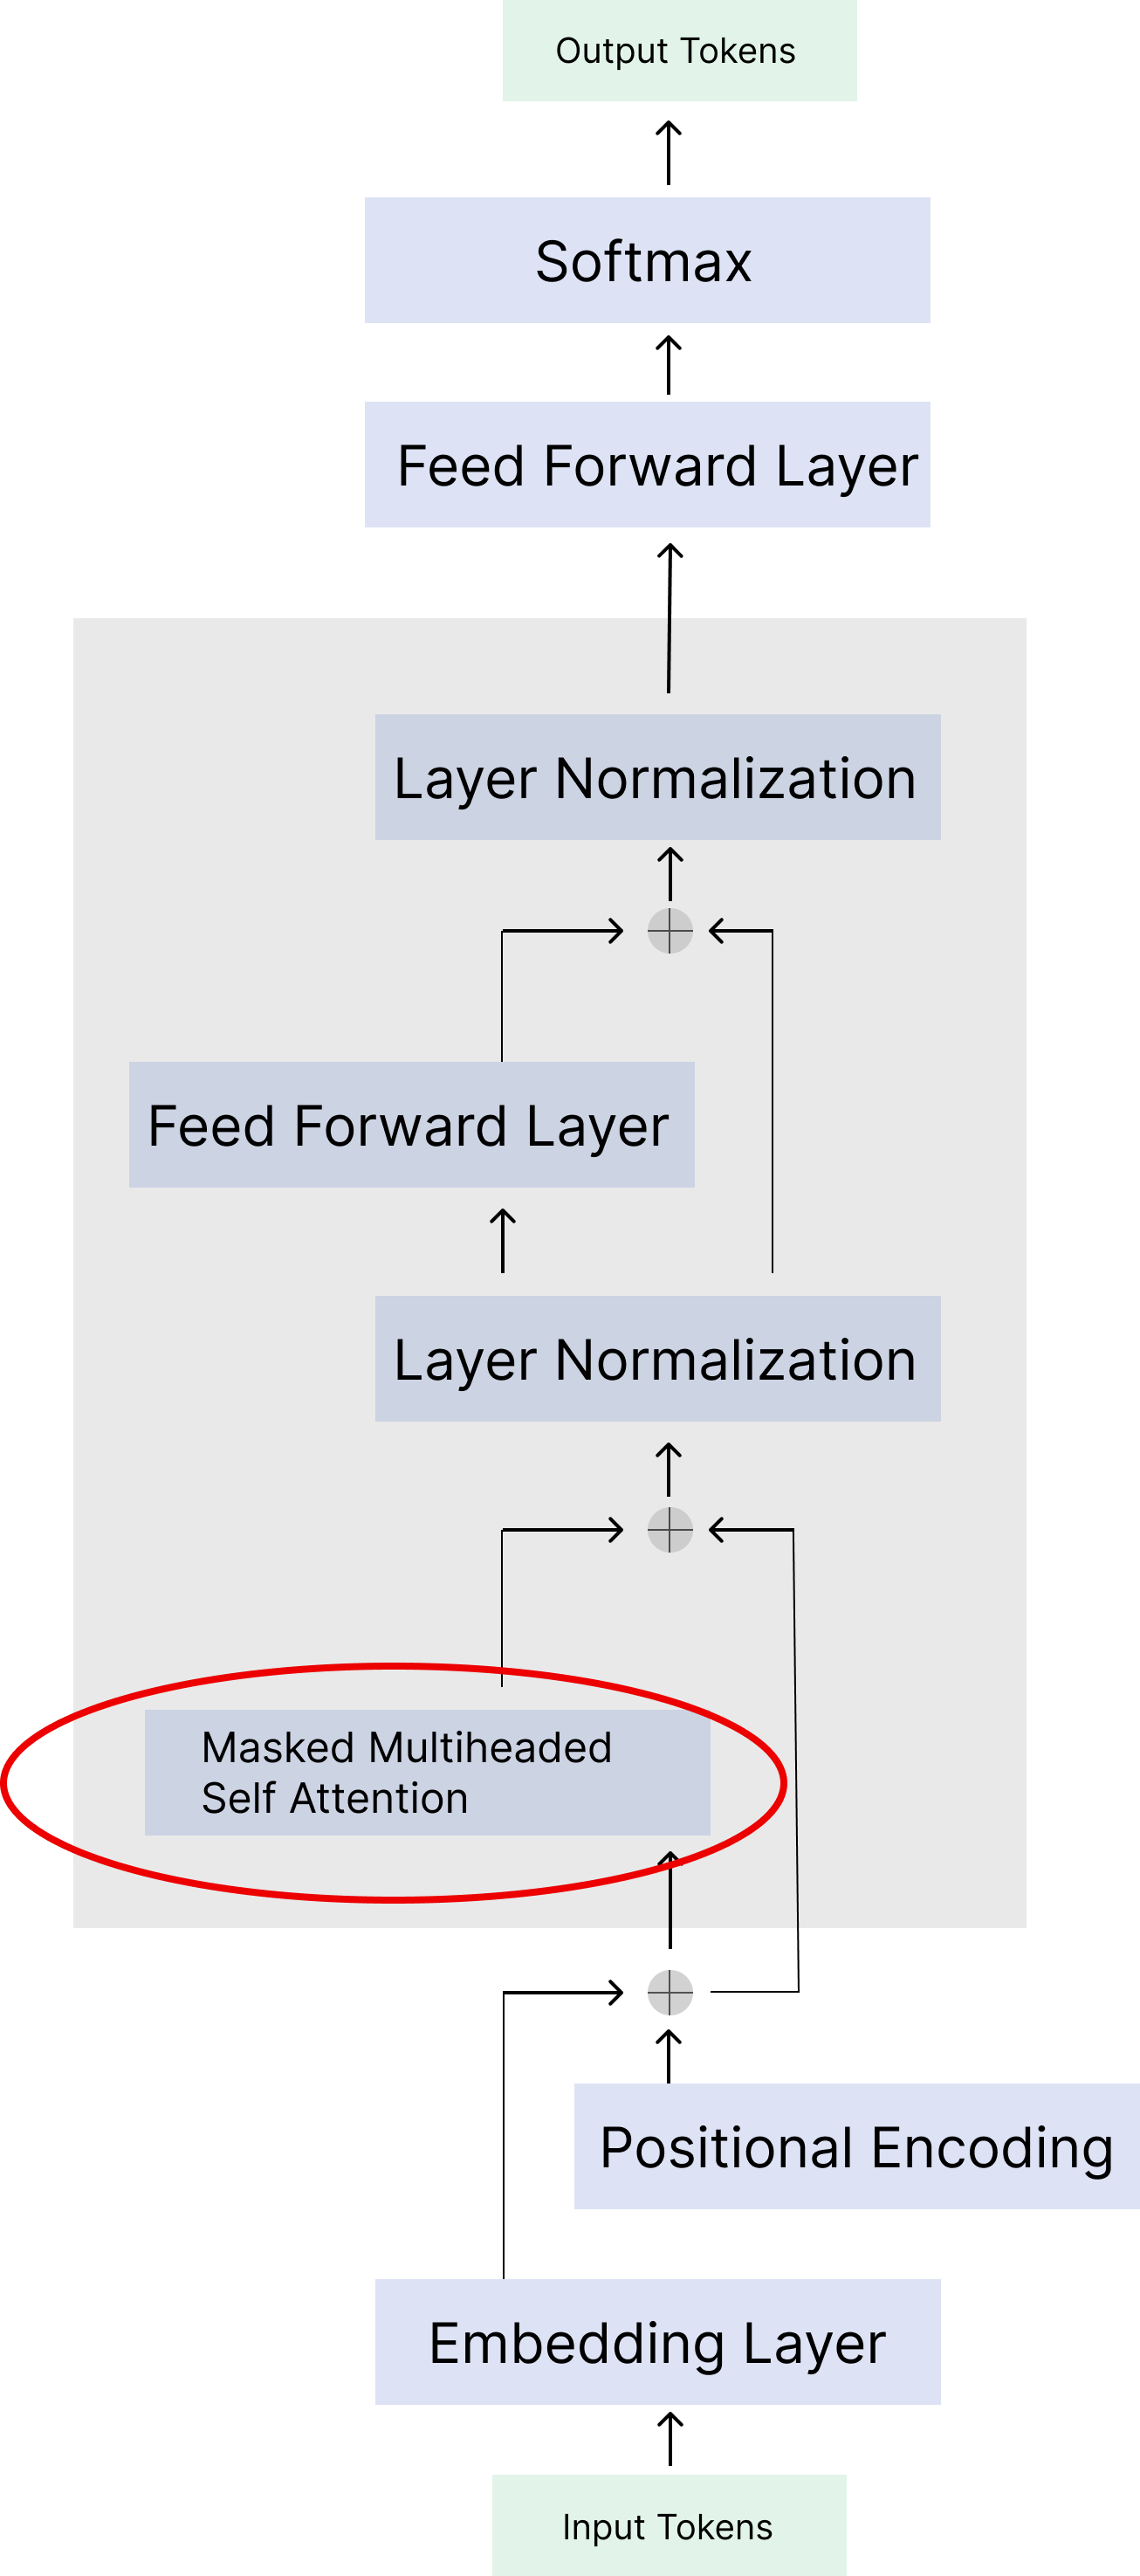

</div>

После позиционного кодирования мы переходим к ядру LLM — трансформатору (только декодеру). Первым шагом трансформатора является маскированное многоголовое самовнимание. Внутреннюю структуру трансформатора можно разделить на три части: самовнимание, затем маскирование, затем многоголовые головы.    

#### Self Attention
Основная идея самовнимания заключается в том, что оно позволяет каждому токену «общаться» с другими токенами. Внимание «переформулирует» значение слова в комбинацию всех других слов в контекстном окне. Один самовнимательный блок выполняет одно из многих возможных «переформулирований» каждого токена. Это позволяет модели понимать контекст каждого слова по отношению к другим словам в предложении.

Самостоятельное внимание начинается только с матрицы встраивания токенов с кодировкой позиций. Оно «разлагает» эту матрицу на запросы, ключи и значения. На самом деле все это просто векторы/матрицы, которые настраиваются во время обучения, но концептуально мы можем думать о них как о запросах, ключах и значениях из-за их операций скалярного произведения, которые происходят в операции внимания.

Исходная формула для масштабированного внимания с помощью скалярного произведения выглядит следующим образом [9]:
$$Attention(Q,K,V)=softmax(\frac{QK^t}{\sqrt{d_k}})V$$

Q, K и V — матрицы запросов, ключей и значений. Изначально они задаются через матричные проекции входной матрицы вложений. Вложения токенов умножаются на матрицы $W_q$, $W_k$ и $W_v$. Эти матрицы весов изначально являются случайными и настраиваются в процессе обучения сети. Это означает, что во время обучения сеть учится, какие «запросы» задавать и какие «ключи» и «значения» устанавливать посредством обратного распространения, настраивая эти матрицы. Она учится преобразовывать матрицу вложения в «ключи», «запросы» и «значения», чтобы максимально уменьшить потери сети.

Операция проекции для генерации Q, K и V показана ниже с использованием размеров для нашего фиктивного набора данных/сети.

<div style="width:700px;margin:auto;">

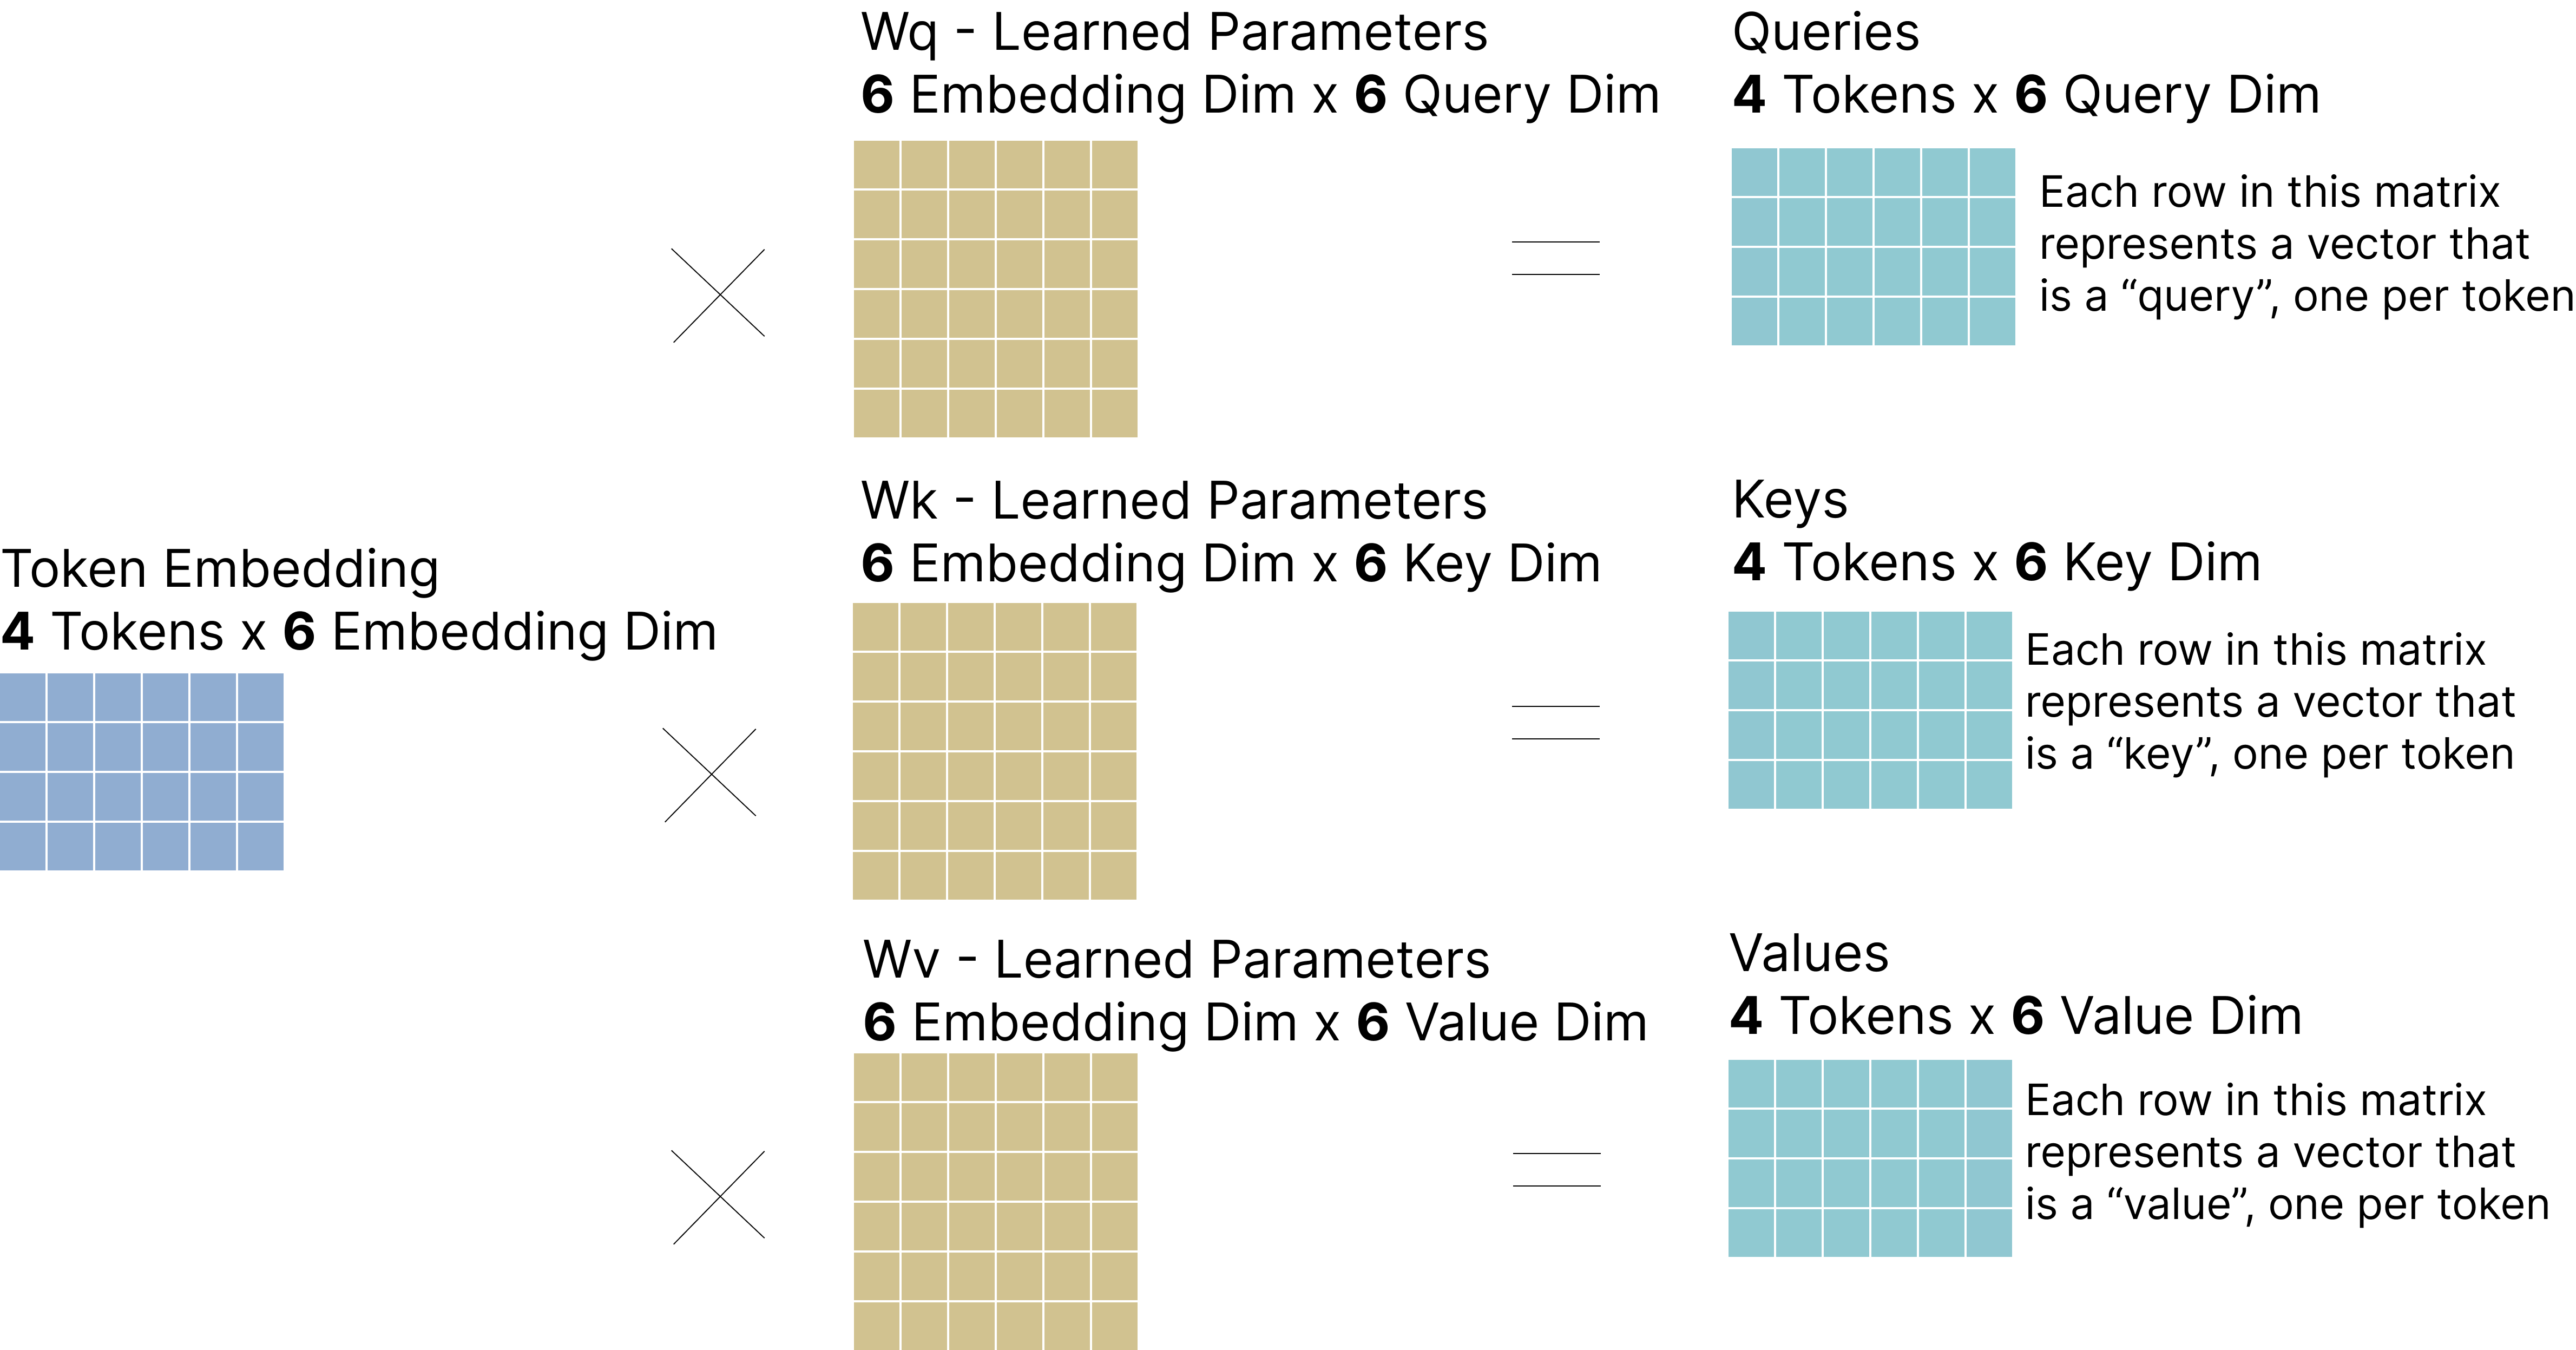

</div>

Q, K и V — это матрицы формы *num tokens x embedding size*. Каждый токен имеет вектор запроса в «пространстве запросов». Каждый токен также имеет вектор ключа в «пространстве ключей». Когда мы выполняем операцию $QK^T$, мы вычисляем, насколько хорошо каждый запрос токена соответствует каждому ключу. Это можно рассматривать как своего рода «нечеткий поиск» с использованием векторных скалярных произведений. Если запрос и ключ имеют высокое скалярное произведение, это означает, что векторы указывают в направлении, близком друг к другу. Это также означает, что эти два токена важно учитывать вместе.

После умножения матриц $Q$ и $K^T$ мы получаем матрицу схожести токенов. Эта матрица схожести показывает, насколько каждый токен связан с другим токеном. Каждая строка матрицы $QK^T$ проходит через функцию softmax, так что каждая строка становится вероятностным распределением, которое в сумме дает единицу. Это вероятностное распределение можно интерпретировать как степень соответствия каждого ключа запросу строки. Насколько каждый ключ «уделяет внимание» каждому запросу.

Матрица значений может рассматриваться как фактическое содержание/информация, которую предлагает каждый токен. Эта матрица значений взвешивается по сходству ключей/запросов для получения окончательного результата самовнимания.   


#### Self Attention: Further Intuition

Существует несколько альтернативных способов представления отдельных операций внимания, которые могут помочь на концептуальном/интуитивном уровне понять, что делает сеть. Давайте рассмотрим каждую операцию внимания и попробуем упростить на английском языке то, что она делает на концептуальном уровне.    

##### Матрицы Q, K, V Интуиция
Мы знаем, что матрицы $Q$, $K$, $V$ создаются с помощью матричной операции над входом трансформатора (для первого блока это наши позиционно-кодированные вложения слов). Мы также знаем, что веса для создания этих матриц настраиваются в процессе обратного распространения. Но как мы можем представить себе эти матрицы? Какую информацию они на самом деле содержат?   

##### Интуитивное понимание матрицы $Q

Матрицу $Q$ можно представить как n строк запросов или вопросов, где n — количество токенов во входных данных. Рассматривая матрицу $Q$, думайте о ней как о n векторах, а не как об одной матрице. Каждый вектор — это запрос или вопрос о соответствующем слове, на который можно ответить с помощью некоторых комбинаций других слов. Помните, что мы «переформулируем» данное слово как некоторую комбинацию других слов. Например, это может выглядеть следующим образом:   

<div style="width:700px;margin:auto;">

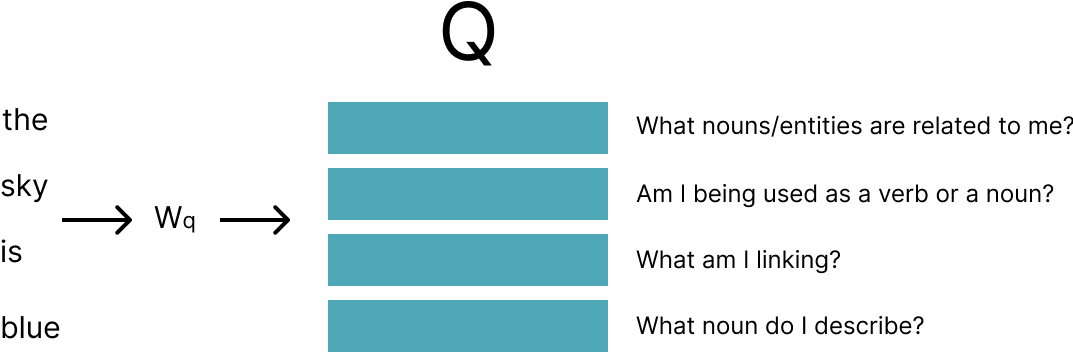    

</div>

В этом случае каждому токену соответствует вопрос. Эти вопросы или запросы будут вопросами, на которые можно ответить с помощью окружающих токенов. Так как же создаются эти вопросы? $W_q$ отвечает за создание правильных вопросов для каждого токена (с позицией). $W_q$ сопоставляет токен с соответствующим запросом об этом токене. Эти запросы становятся релевантными в процессе обучения с помощью обратного распространения.    


##### Матрица $K$ Интуиция
Мы можем представить матрицу $K$ как n строчных векторов ключей, где n — количество токенов во входных данных. Что мы имеем в виду под «ключами»? Проще всего представить ключи как факты, которые могут помочь ответить на запросы. Выше, в разделе о запросах, мы задавали вопросы типа «какое существительное я описываю?». Ключом, который может точно соответствовать этому запросу, будет «Я — существительное, которое можно описать». Подобно запросам, $W_k$ создает эти ключи, обучаясь правильному сопоставлению токена с соответствующим ключом. Эти ключи хорошо подходят для запросов благодаря операции $QK^T$, которая выполняется при обучении. 

<div style="width:700px;margin:auto;">

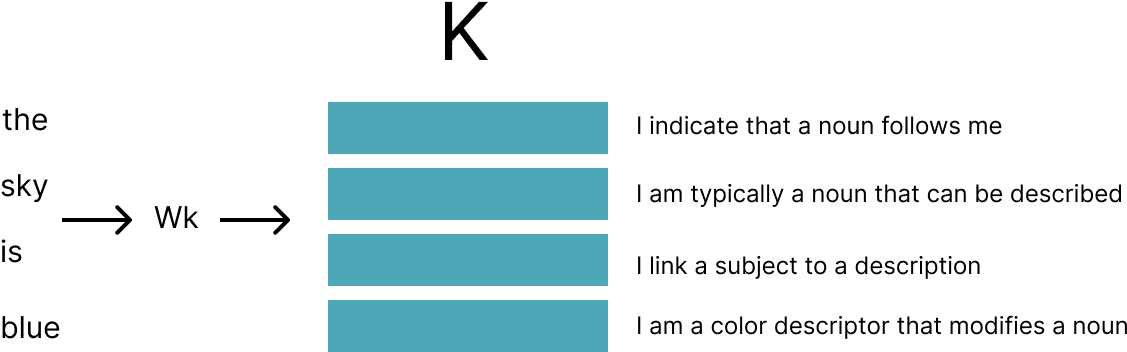

</div>

В целом, каждый ключ можно рассматривать как факт об этом токене, который может помочь ответить на запросы, которые могут иметь другие токены. 


##### Интуитивное понимание операции $QK^T$:

Теперь, когда мы имеем интуитивное понимание матриц $Q$ и $K$, мы можем подумать о том, что делает операция умножения матриц $QK^T$ в уравнении внимания. Операция $QK^T$ является операцией сопоставления, при которой каждый запрос сравнивается с каждым ключом путем выполнения операции скалярного произведения. Если скалярное произведение велико, это означает, что ключ отвечает на запрос или «обращает внимание» на него. Если скалярное произведение мало, это означает, что ключ не имеет отношения к запросу и не помогает ответить на него. Операция $QK^T$ «переформулирует» каждый запрос в набор ключей. Результирующая матрица операции может рассматриваться как n векторов строк. Каждое измерение или координата этих векторов строк является весом для ключа/факта токена. Таким образом, вектор в этом пространстве представляет собой некоторую взвешенную комбинацию всех токенов (ключей).

По сути, мы переописываем исходный запрос/вопрос токена как взвешенный вектор всех ключей/ответов токена. Вместо того, чтобы задавать вопрос о токене, мы имеем n различных ответов, каждый со своим собственным весом.

При выполнении операции $QK^T$ мы преобразуем векторы строк запроса в комбинацию ключей. Помните, что каждый запрос связан с тем, как этот токен соотносится с другими токенами, поэтому ответы могут быть сформированы как некоторая комбинация других токенов. 

<div style="width:700px;margin:auto;">

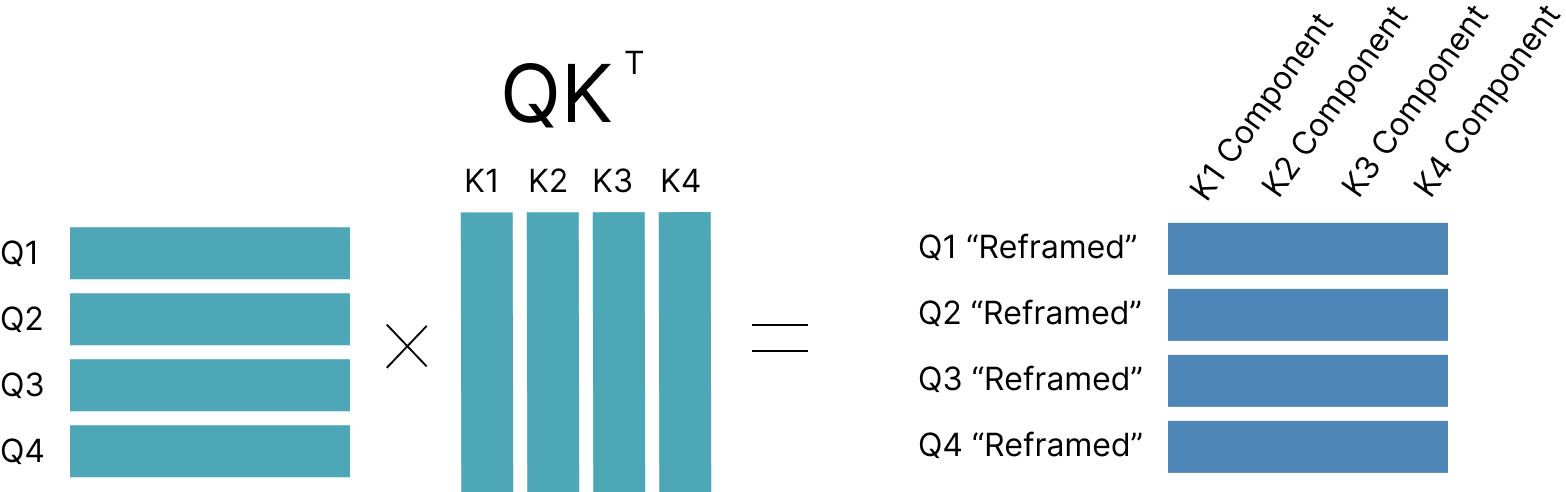

</div>

##### $\frac{QK^T}{\sqrt{d_k}}$ Интуитивное понимание операции:

Эта операция выполняется для того, чтобы сделать выходные данные softmax более стабильными. Скалярное произведение двух случайных векторов размерности $d_k$ дает значения, которые имеют тенденцию расти пропорционально $d_k$. Это гарантирует, что независимо от того, насколько велико $d_k$, softmax работает как ожидается и не приводит к экстремальным значениям.

Это деление по элементам, поэтому каждый элемент матрицы делится на это значение. Результирующую матрицу можно рассматривать так же, как результат $QK^T$, только масштабированный.

##### Операция $softmax(\frac{QK^T}{\sqrt{d_k}})$ Интуитивное понимание:

Операция softmax выполняется построчно над матрицей $\frac{QK^T}{\sqrt{d_k}}$. Это означает, что каждая строка приводит к распределению вероятностей.
Мы по-прежнему можем думать об этом как о том, что каждый токен представлен в виде «переформулированного» вектора запроса, но теперь мы знаем, что каждый вектор строки в сумме дает единицу.

##### Матрица $V$ Интуиция

Матрица $V$ немного сложна для понимания, но ее можно представить как столбцовую матрицу, где каждый столбец является обученной особенностью, а каждый элемент этих векторов — значением этой особенности для токена в этой строке. Это векторы «особенностей», которые содержат информацию об определенных обученных особенностях для каждого токена. Когда мы выполняем окончательную операцию, эти векторы признаков будут взвешены, что означает, что значения этих признаков для определенных токенов должны быть более значимыми, чем для других токенов. Матрица $V$ является фактическим содержанием или результатом внимания. Это содержание будет скорректировано весами из операции $softmax(\frac{QK^T}{\sqrt{d_k}})$

<div style="width:300px;margin:auto;">

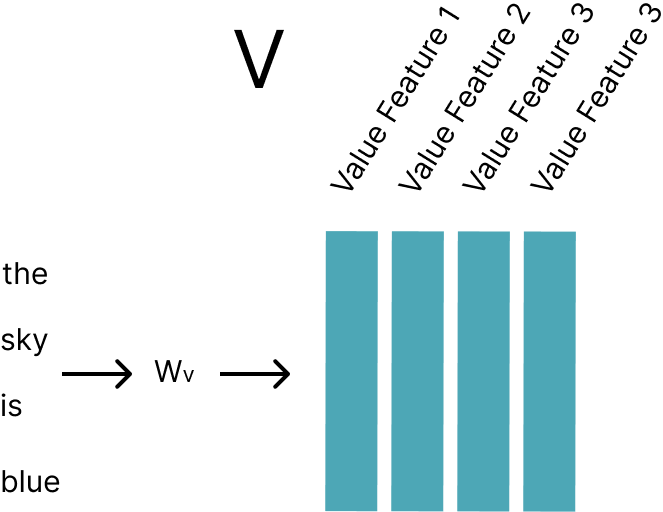

</div>


##### $softmax(\frac{QK^T}{\sqrt{d_k}})V$ Интуитивное понимание операции:

Теперь перейдем к последней операции внимания — умножению на матрицу $V$. Матрицу V можно рассматривать как содержащую исходное содержимое вложений. Мы взвешиваем это содержание на основе совпадений запроса/ключа. Другими словами, мы взвешиваем содержание на основе конкретных вопросов, которые мы пытаемся задать, и того, как другие слова в контексте отвечают на эти вопросы.


$$softmax(\frac{QK^T}{\sqrt{d_k}})V$$

<div style="width:900px;margin:auto;">

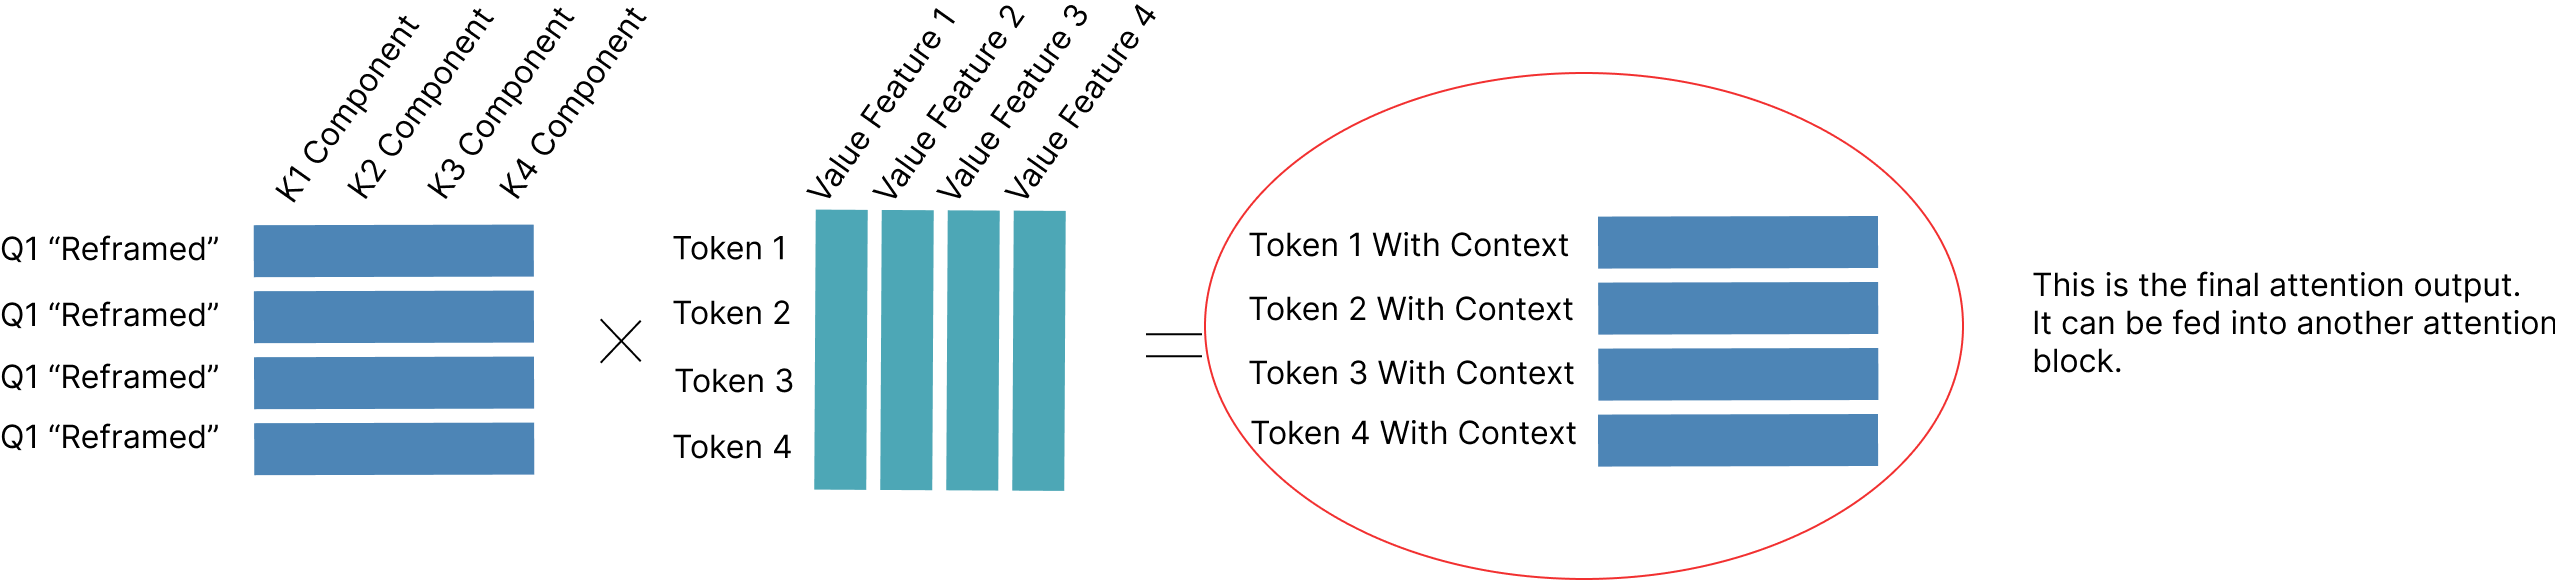

</div>

Сложив все это вместе (используя исходные размеры нашего «test» конфигурационного объекта, как в коде), мы можем увидеть все матричные операции и размеры через операцию самовнимания.    

<div style="width:1000px;margin:auto;">

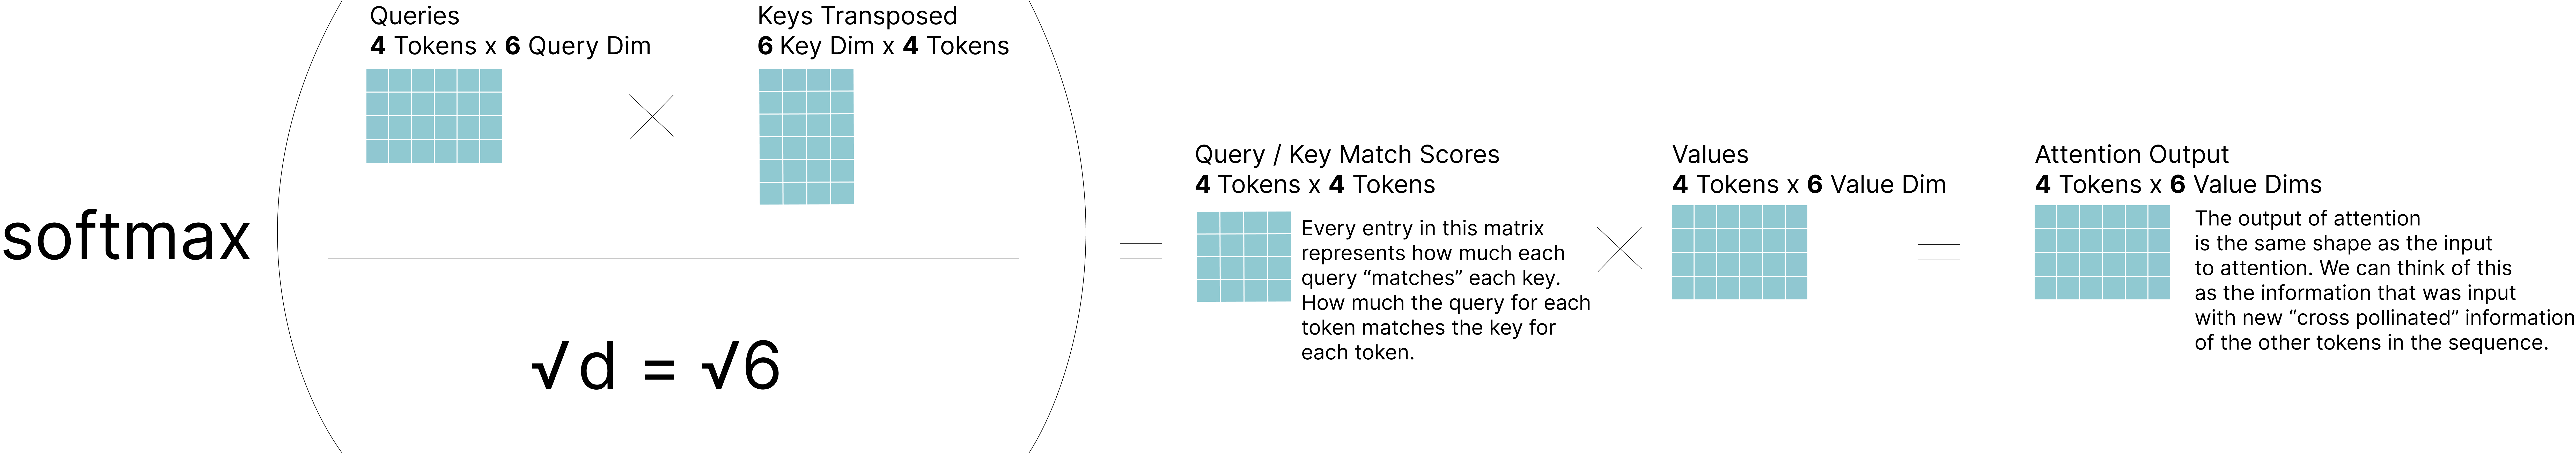 

</div>

#### Self Attention: Code

Самостоятельное внимание можно записать в виде самостоятельного модуля pytorch, как показано ниже.



In [8]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Query weights - will transform input embeddings into queries
        self.Wk = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Key weights - will transform input embeddings into keys
        self.Wv = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Value weights - will transform input embeddings into values

    def forward(self, x):
        print("Attention input shape:", x.shape)
        print("")
        print("Query weights shape:", self.Wq.shape)
        print("Key weights shape:", self.Wk.shape)
        print("Value weights shape:", self.Wv.shape)
        queries = x @ self.Wq # Matrix multiplication to transform input embeddings into queries
        keys = x @ self.Wk # Matrix multiplication to transform input embeddings into keys
        values = x @ self.Wv # Matrix multiplication to transform input embeddings into values
        print("")
        print("Queries shape:", queries.shape)
        print("Keys shape:", keys.shape)
        print("Values shape:", values.shape)

        qkt = queries @ keys.transpose(-2, -1) # Calculate QK^T
        qkt_scaled = qkt / math.sqrt(queries.size(-1)) # Scale QK^T by the dimension of the keys
        qkt_softmax = F.softmax(qkt_scaled, dim=-1) # Apply softmax row-wise to get attention weights
        print("")
        print("QK^T shape:", qkt.shape)

        attn_output = qkt_softmax @ values # Multiply softmax(QK^T) by values
        print("")
        print("Attention output shape:", attn_output.shape)
        return attn_output 

attention = SelfAttention(test_config)
test_out = attention(test_embeddings_with_pos)

Attention input shape: torch.Size([2, 4, 6])

Query weights shape: torch.Size([6, 6])
Key weights shape: torch.Size([6, 6])
Value weights shape: torch.Size([6, 6])

Queries shape: torch.Size([2, 4, 6])
Keys shape: torch.Size([2, 4, 6])
Values shape: torch.Size([2, 4, 6])

QK^T shape: torch.Size([2, 4, 4])

Attention output shape: torch.Size([2, 4, 6])


#### Causal Self Attention

Теперь, когда мы реализовали самовнимание, мы можем перейти к причинному самовниманию. Во время обучения мы пытаемся предсказать следующий токен на каждом временном шаге параллельно в трансформаторе. Однако мы будем обманывать, если позволим вниманию видеть будущие токены во время процесса обучения. Оно просто будет предсказывать будущие токены, глядя на них. По этой причине нам нужно замаскировать матрицы, чтобы будущие токены были скрыты от слоев самовнимания. Мы выполняем это маскирование после операции $QK^T$ [11].

<div style="width:400px;margin:auto;">

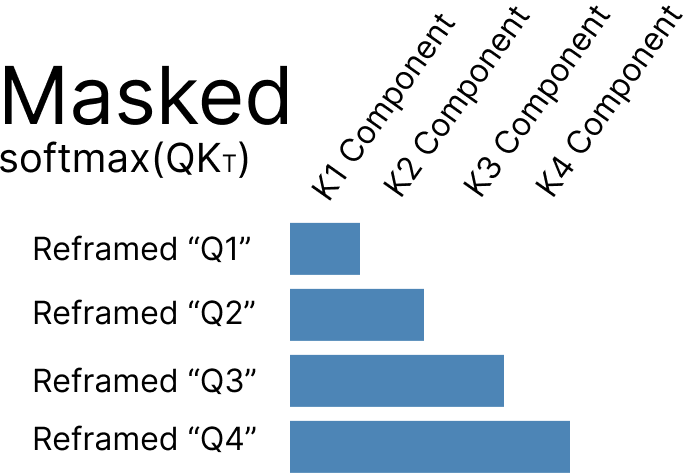

</div>

Процесс маскирования делает результат операции softmax равным 0 в правом верхнем углу. Это приводит к следующему:
- Запрос для токена 1 может быть переформулирован только как комбинация токена 1
- Запрос на токен 2 может быть переформулирован только как комбинация токенов 1 и 2
- Запрос на токен 3 может быть переформулирован только как комбинация токенов 1, 2 и 3
- Запрос на токен 4 может быть переформулирован только как комбинация токенов 1, 2, 3 и 4
- и т. д.

*Когда мы говорим, что запрос можно переформулировать, с математической точки зрения мы имеем в виду, что значение в этой ячейке матрицы может быть больше 0.*

Мы можем изменить наш блок самовнимания выше, чтобы добавить маскирование, внеся следующие изменения:

In [9]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Query weights - will transform input embeddings into queries
        self.Wk = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Key weights - will transform input embeddings into keys
        self.Wv = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Value weights - will transform input embeddings into values

    def forward(self, x):
        seq_len = x.shape[1] # Get sequence length (number of tokens / context window length)
        queries = x @ self.Wq # Matrix multiplication to transform input embeddings into queries
        keys = x @ self.Wk    # Matrix multiplication to transform input embeddings into keys
        values = x @ self.Wv  # Matrix multiplication to transform input embeddings into values
        qkt = queries @ keys.transpose(-2, -1)  # Calculate QK^T
        qkt_scaled = qkt / math.sqrt(queries.size(-1))  # Scale QK^T by the dimension of the keys

        # MASKING
        # THIS IS THE ONLY DIFFERENCE, USE -inf FOR UPPER TRIANGLE MASK SO THAT SOFTMAX WILL BE 0
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1)
        causal_mask = causal_mask.masked_fill(causal_mask == 1, float('-inf'))  # Upper triangle masked with -inf 
        qkt_scaled = qkt_scaled + causal_mask # Add the mask to the scaled QK^T
        # END MASKING

        qkt_softmax = F.softmax(qkt_scaled, dim=-1) # Apply softmax row-wise to get attention weights, the -inf values will become 0 here
        attn_output = qkt_softmax @ values # Multiply softmax(QK^T) by values
        return attn_output


attention = CausalSelfAttention(test_config)
test_out = attention(test_embeddings_with_pos)
print(test_out.shape)  # Output should have shape: (batch_size, seq_len, n_embd)

torch.Size([2, 4, 6])


#### Multi-Headed Causal Self Attention

Теперь, когда у нас есть причинное самовнимание, мы можем добавить «multi-headed» часть слоя внимания. Мы можем сделать это, соединив несколько операций CausalAttention параллельно. Затем мы добавляем слой, чтобы проецировать окончательный вывод обратно на размер входа.  

##### Multi-Headed Causal Self Attention intuition

Что это на самом деле означает с концептуальной точки зрения? Это позволяет каждой голове обращать внимание на токены по-разному. Например, одна голова может сосредоточиться на грамматической структуре, другая — на семантическом значении, а третья — на значении в реальном мире. Если рассматривать предложение «небо голубое» с точки зрения грамматической структуры, слово «небо» может сильно привлекать внимание слова «the», потому что оно относится именно к нему. Однако, если рассматривать внимание через призму реального значения, слово «the» не будет уделять особого внимания слову «sky», потому что их значения не схожи. Отношение каждого слова к другим словам может быть разным в зависимости от того, через какую «призму» (или «голову») вы их рассматриваете.    

Повторим, что это полезный концептуальный способ думать о многоголовом внимании, но значения каждой головы не всегда понятны человеку таким образом. Они будут принимать любое значение, которое поможет максимально минимизировать функцию потери обучающего набора.

Конечный результат Multi-Headed Causal Self Attention имеет точно такой же размер, как и входные данные, благодаря конечному слою прямой передачи, который проецирует сцепленные результаты внимания обратно вниз. 


##### Multi-Headed Causal Self Attention Code

Следующий фрагмент кода показывает реализацию многоголового причинного самовнимания, основанную на наших предыдущих блоках внимания. Это не самая вычислительно эффективная реализация из-за цикла for для каждой головы, но она легче читается, чем полностью векторизованная версия, и подходит для нашего случая использования из-за небольших наборов данных, которые мы используем.

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn_heads = nn.ModuleList([
            CausalSelfAttention(config) for _ in range(config.n_head)
        ])  # Create n_head attention heads
        self.projection = nn.Linear(config.n_embd * config.n_head, config.n_embd).to(device) # Linear layer to project multi-head attention outputs

    def forward(self, x):
        head_outputs = [head(x) for head in self.attn_heads] # Get the output of each attention head
        multihead_output = torch.cat(head_outputs, dim=-1) # Concatenate the outputs
        return self.projection(multihead_output) # Project the concatenated outputs

multihead_attn = MultiHeadAttention(test_config)
test_out = multihead_attn(test_embeddings_with_pos)
print(test_out.shape)  # Output should have shape: (batch_size, seq_len, n_embd)

torch.Size([2, 4, 6])


### 1.3.5 The Block

Теперь мы успешно реализовали многоголовное внимание. Осталось всего несколько шагов, чтобы получить «блок» GPT, который мы сможем многократно накладывать на сеть. Архитектура блока GPT выглядит следующим образом:

<div style="width:400px;margin:auto">

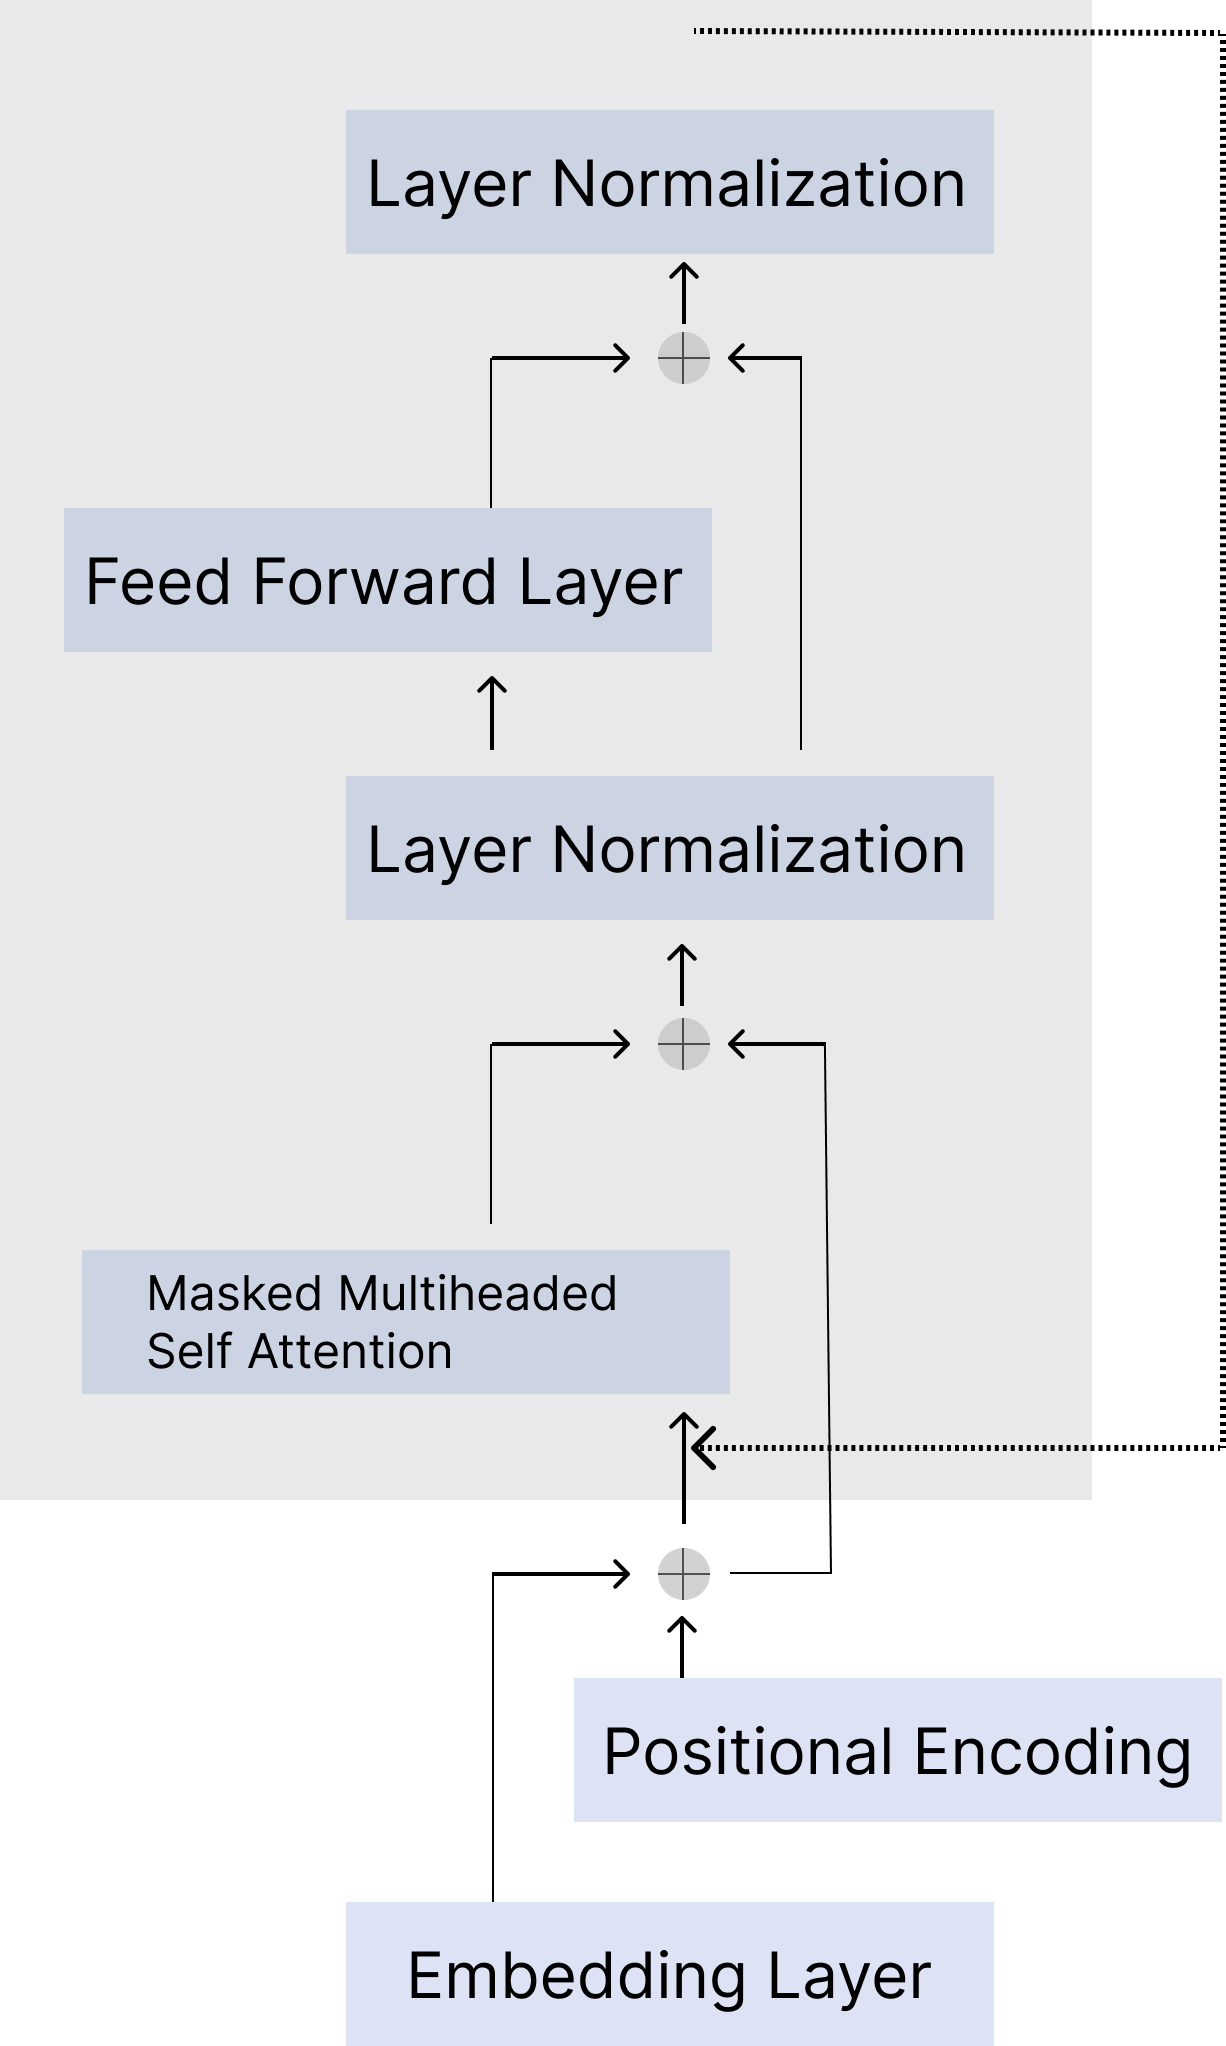

</div>

До сих пор мы создали части встраивания текста, позиционного кодирования и маскированного многоголового самовнимания. Теперь нам нужно добавить слои нормализации и слои прямой передачи. Это простые слои pytorch, которые являются общими для многих архитектур нейронных сетей.

### Layer normalization layers
Слои нормализации слоев просты и используются во многих архитектурах глубокого обучения. Они нормализуют значения входящей матрицы по размеру признака (в нашем случае размер 2). Используются для стабилизации обучения и достижения более быстрой сходимости.

#### Feedforward layer
Прямой слой блока трансформатора работает по другой парадигме, чем внимание. В то время как внимание фиксирует отношения между токенами, прямой слой применяет одно и то же преобразование к каждому токену параллельно. Его можно реализовать с помощью стандартных линейных слоев pytorch. Мы используем коэффициент 4 x размер вложения для размера линейного слоя, как это было сделано в оригинальной статье «Внимание — это все, что вам нужно». Мы используем функцию активации Gaussian Error Linear Unit (GELU), как это реализовано в оригинальной статье GPT.

In [11]:
class GPTBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.mha = MultiHeadAttention(config)
        self.ln1 = nn.LayerNorm(config.n_embd).to(device)
        self.ffn = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        ).to(device)
        self.ln2 = nn.LayerNorm(config.n_embd).to(device)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

block = GPTBlock(test_config)
test_out = block(test_embeddings_with_pos)
print(test_out.shape)  # Output should have shape: (batch_size, seq_len, n_embd)

torch.Size([2, 4, 6])


### 1.3.6 Объединение всех компонентов


Теперь, когда у нас есть блок, мы можем сложить несколько блоков вместе, чтобы получить модель LLM в стиле GPT.

In [12]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd).to(device)
        self.position_encoding = get_position_encoding(config.seq_len, config.n_embd)
        self.blocks = nn.Sequential(*[GPTBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd).to(device)
        self.head = nn.Linear(config.n_embd, config.vocab_size).to(device)
    
    def forward(self, x):
        x = self.token_embedding(x) + self.position_encoding
        x = self.blocks(x)
        x = self.ln_f(x)
        return self.head(x)
    
gpt = GPTModel(test_config)
print(test_batch_inputs.shape)
test_out = gpt(test_batch_inputs)
print(test_out.shape)  

torch.Size([2, 4])
torch.Size([2, 4, 50257])


Это полный прямой проход через LLM, входные данные имеют форму $[batch,tokens]$, а выходные данные — форму $[batch,tokens,probabilities]$. Для каждого токена, заданного во входных данных, LLM прогнозирует дискретное распределение вероятностей следующего токена, который идет после него.

Трансформатор делает несколько прогнозов параллельно, по одному для каждого токена во входных данных. Хотя все они используются в обучении, только последний прогноз (токена n) используется в выводе для окончательного прогноза.

На следующей диаграмме показан полный прямой проход с формами, когда один пример проходит через матрицу.

<div style="width:600px;margin:auto">

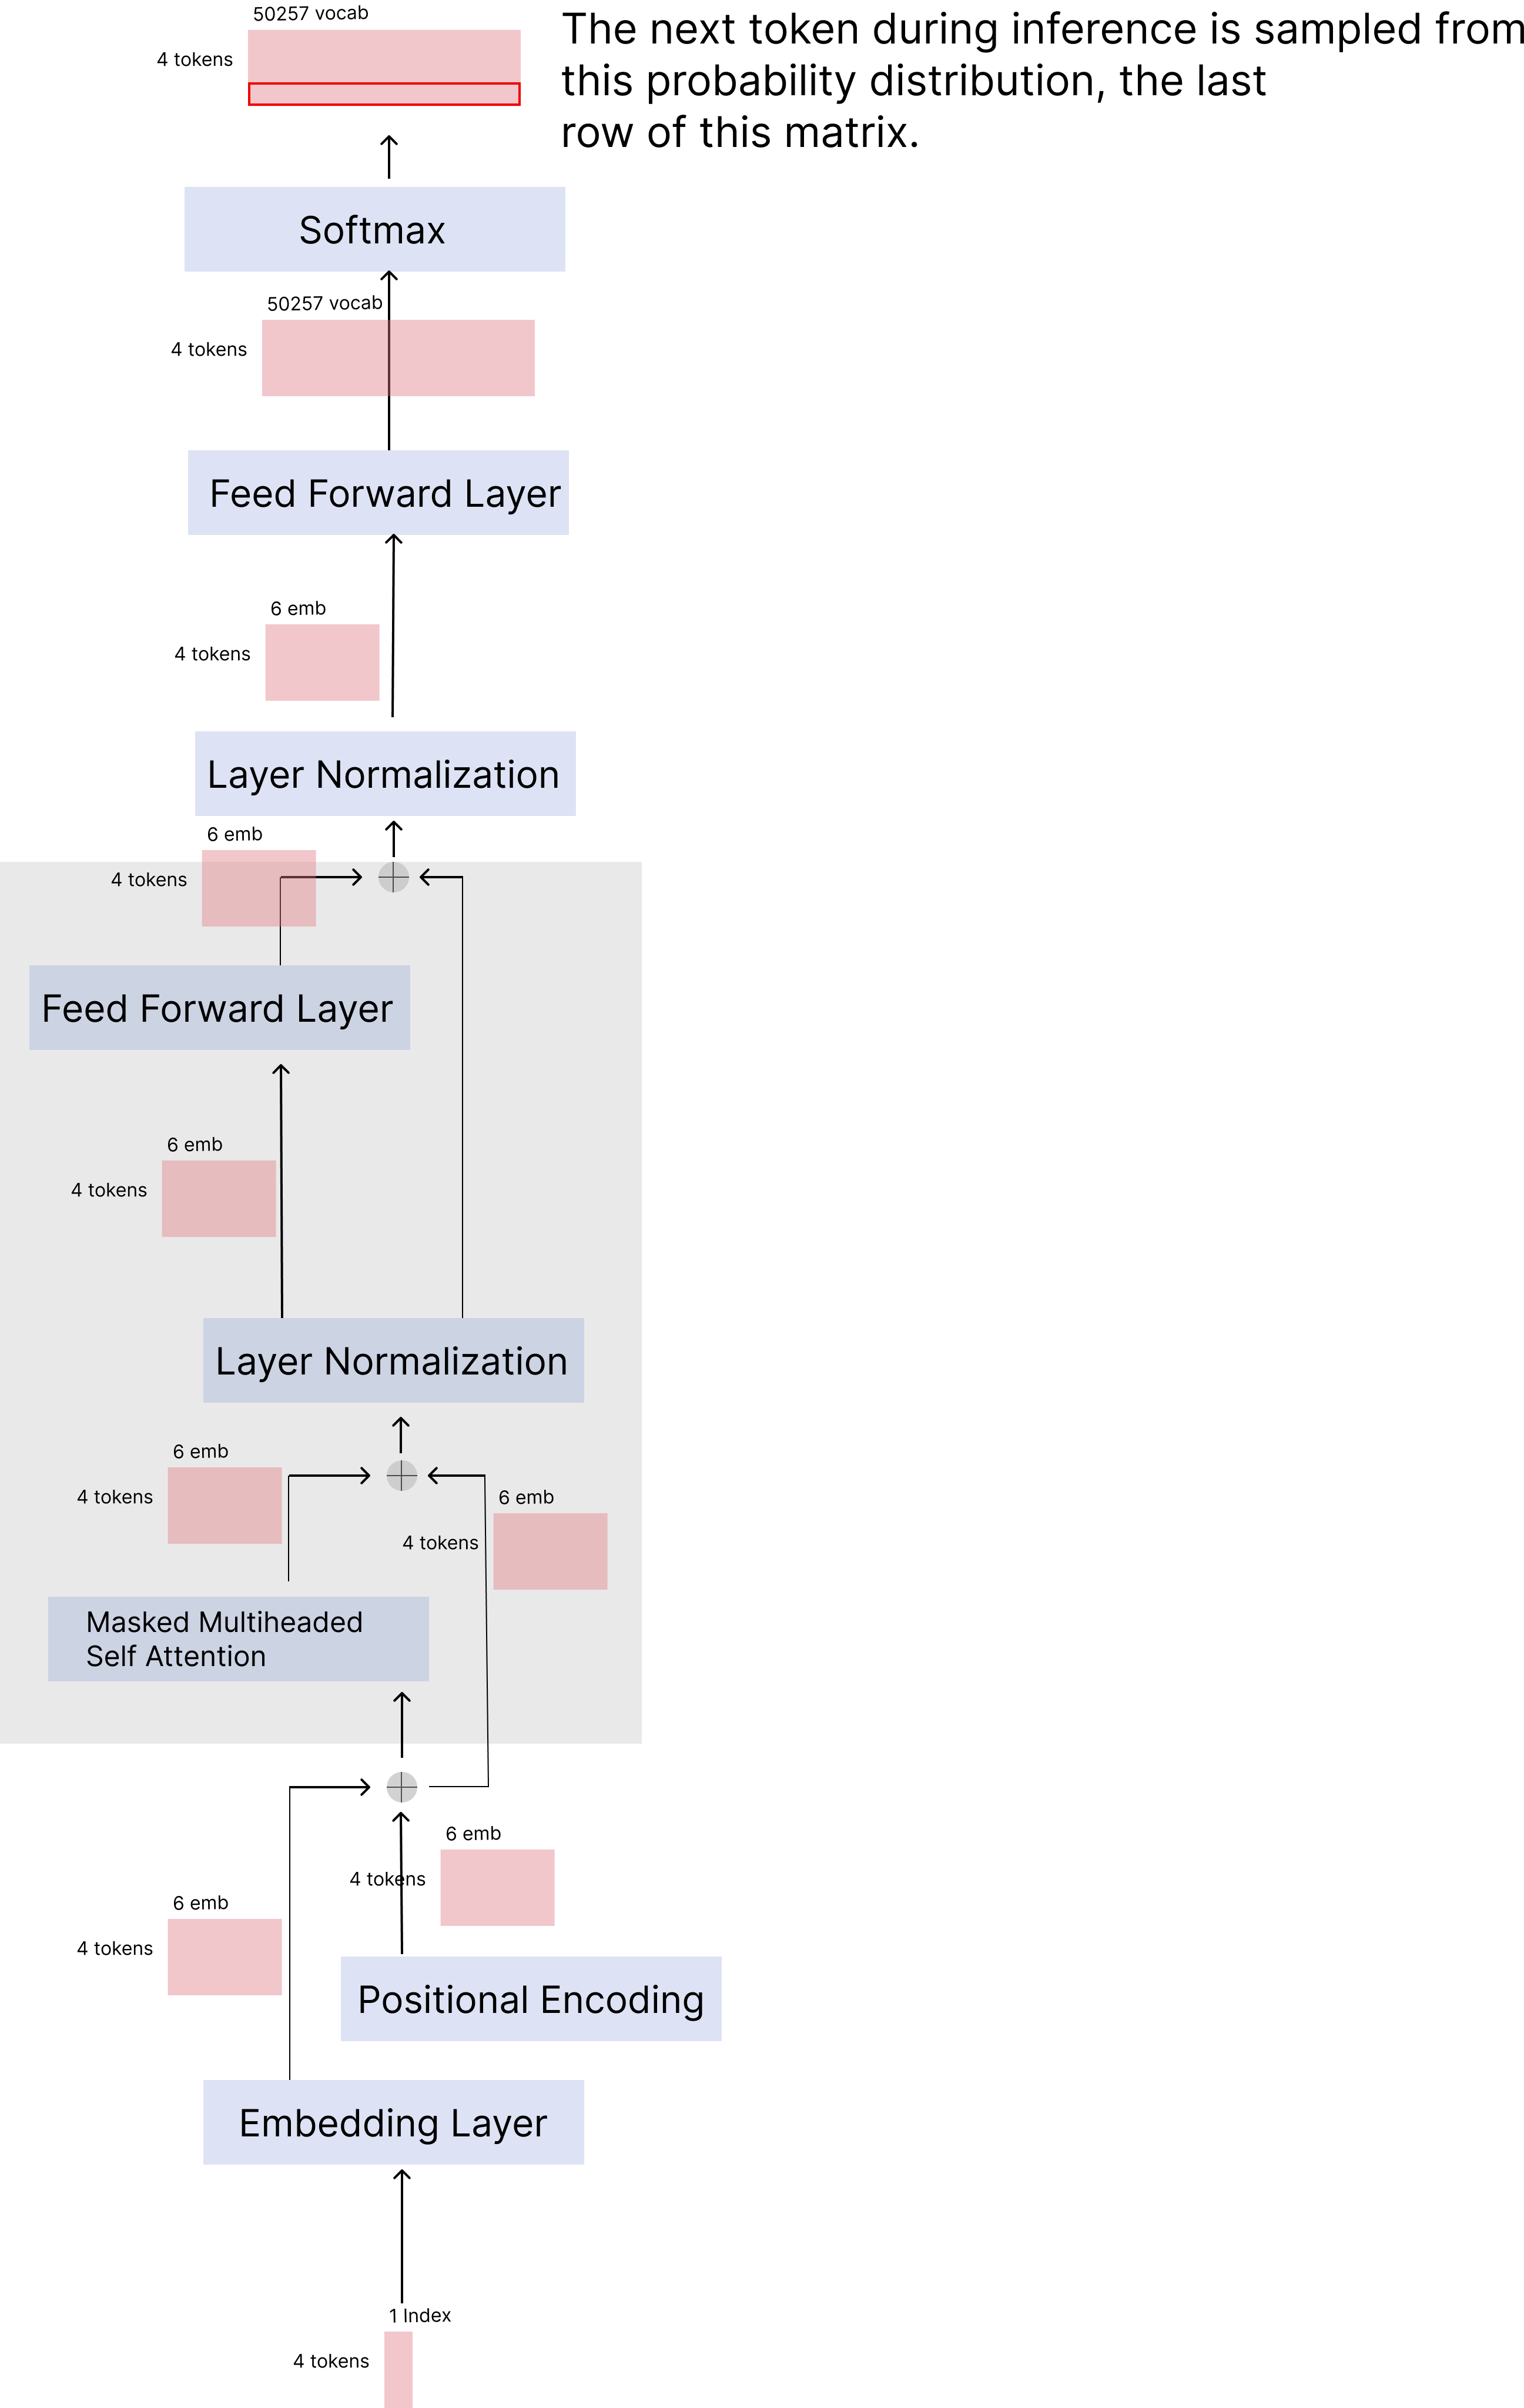

</div>

### 1.3.7 Цикл обучения с фиктивными данными

Теперь, когда мы прошли прямой проход модели, мы можем ее обучить. Модель обучается с помощью прогнозирования следующего токена

#### Целевая функция

Согласно оригинальной статье о GPT, целевая функция предварительного обучения следующая [1]:  

$$L1(U) = \sum_{i}logP(u_i|u_{i-k}...u_{i-1};\theta)$$

- $U$ — последовательность текста (токенов), для которой мы вычисляем целевую функцию
- $u_i$ — текущий токен последовательности
- $u_{i-k}...u_{i-1}$ — предыдущие k токенов (контекстное окно)
- $P(u_i|u_{i-k}...u_{i-1};\theta)$ — вероятность предсказания $u_i$ с учетом предыдущих токенов $u_{i-k}...u_{i-1}$ и параметров модели $\theta$
- Мы берем логарифм этого значения из-за его полезных свойств в оптимизации
- Затем мы берем сумму всех токенов в последовательности
- Таким образом, на английском языке мы можем найти вероятность предсказания токена на основе предыдущих k токенов и весов модели. Мы хотим максимизировать эту вероятность для всех токенов в последовательности.


Максимизация этой целевой функции по сути аналогична минимизации функции потери кросс-энтропии.

$$H(p, q) = -\sum_{x} p(x) \log q(x)$$

- Где p(x) — истинное дискретное распределение вероятностей классов 
- q(x) — предсказанное дискретное распределение вероятностей классов

Это связано с тем, что во время обучения мы используем вектор с кодировкой «один горячий» для истинного распределения, поэтому p(x) равно 1 для правильного токена и 0 для всех других токенов. Это означает, что мы можем удалить сумму и упростить потерю кросс-энтропии до следующего вида:


$$H(p, q) = -\log P(u_i \mid u_{i-k}, \dots, u_{i-1}; \theta)$$

Pytorch имеет встроенную функцию потери кросс-энтропии, которую можно использовать в качестве критерия для минимизации [12].


#### Тест 1: Переобучение
Сначала мы обучим модель на небольшом наборе данных (10 примеров) и посмотрим, сможем ли мы заставить модель запомнить/переобучить набор данных. Это хороший тест, чтобы убедиться, что наша архитектура правильная и потери уменьшаются, как и ожидалось.



In [13]:
# Example config:
batch_size = 10
sequence_len = 128
num_steps = 1000
train_inputs, train_targets, _, _ = get_dataset(10, sequence_len, 0)
config = GPTConfig(
    vocab_size=tokenizer.n_vocab,
    n_layer=4,   # fewer layers for a quick demo
    n_head=4,
    n_embd=128,
    seq_len=sequence_len,
)


# Create the GPT model
model = GPTModel(config)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.2, patience=20, min_lr=5e-6, threshold=1e-4)

# Training loop
i = 1
losses = []

while i < num_steps:
    for j in range(0, len(train_inputs), batch_size):
        x = train_inputs[j:j+batch_size]
        y = train_targets[j:j+batch_size]

        # Forward pass
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        losses.append(loss.item())
        
        optimizer.step()
        optimizer.zero_grad()
    

        loss = loss.item()
        scheduler.step(loss)

   
        # Print the average loss for the epoch
        lr = optimizer.param_groups[0]["lr"]
        print(f"Step {i+1}/{num_steps}, Loss: {loss}, LR: {lr}")

        i += 1


Step 2/1000, Loss: 10.967658996582031, LR: 0.0005
Step 3/1000, Loss: 10.85688591003418, LR: 0.0005
Step 4/1000, Loss: 10.777162551879883, LR: 0.0005
Step 5/1000, Loss: 10.668031692504883, LR: 0.0005
Step 6/1000, Loss: 10.585840225219727, LR: 0.0005
Step 7/1000, Loss: 10.469751358032227, LR: 0.0005
Step 8/1000, Loss: 10.38199234008789, LR: 0.0005
Step 9/1000, Loss: 10.281015396118164, LR: 0.0005
Step 10/1000, Loss: 10.190533638000488, LR: 0.0005
Step 11/1000, Loss: 10.084761619567871, LR: 0.0005
Step 12/1000, Loss: 9.972481727600098, LR: 0.0005
Step 13/1000, Loss: 9.863290786743164, LR: 0.0005
Step 14/1000, Loss: 9.741707801818848, LR: 0.0005
Step 15/1000, Loss: 9.62871265411377, LR: 0.0005
Step 16/1000, Loss: 9.505171775817871, LR: 0.0005
Step 17/1000, Loss: 9.385248184204102, LR: 0.0005
Step 18/1000, Loss: 9.266453742980957, LR: 0.0005
Step 19/1000, Loss: 9.146824836730957, LR: 0.0005
Step 20/1000, Loss: 9.02399730682373, LR: 0.0005
Step 21/1000, Loss: 8.89885425567627, LR: 0.0005
Ste

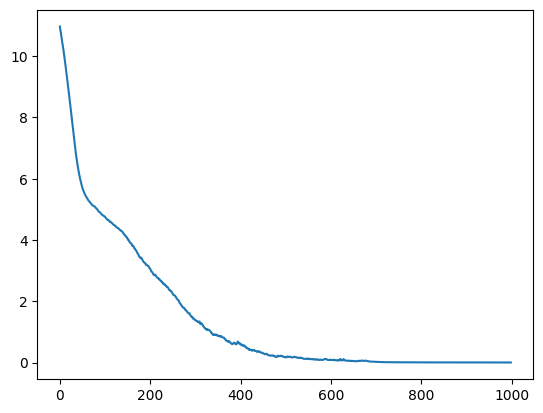

In [14]:
plt.plot(losses)

### 1.3.8 Тест 2: Запоминание

Для выполнения инференции мы можем авторегрессивно подавать данные в трансформер, возвращая выбранный выходной токен обратно во входные данные. Мы можем протестировать это на одном из наших учебных примеров и убедиться, что наша модель точно воспроизводит учебный пример. Модель была переобучена на данных, поэтому мы тестируем, воспроизводит ли модель правильные выходы в том же порядке, что и входы. 

In [15]:
def inference(prompt, max_new_tokens):
    tokens = tokenizer.encode(prompt)
    for _ in range(max_new_tokens):
        num_tokens = len(tokens)
        tokens_padded = tokens + [tokenizer.eot_token] * (config.seq_len - num_tokens)
        tokens_padded = torch.tensor(tokens_padded).unsqueeze(0).to(device)
        logits = model(tokens_padded)
        predicted_token = torch.argmax(logits[0, num_tokens-1, :]).item()
        tokens.append(predicted_token)
    return tokenizer.decode(tokens)
    
print("Original: ", tokenizer.decode(train_inputs[2].tolist())[:90])
print("Predicted:", inference(" director Takeshi Ozawa . A large team of writers handled the script", max_new_tokens=6))

Original:   director Takeshi Ozawa . A large team of writers handled the script . The game 's opening
Predicted:  director Takeshi Ozawa . A large team of writers handled the script . The game 's opening


## 1.4 Реальный цикл обучения

Используя tiktoken и небольшой набор данных, мы смогли переобучить небольшой набор данных и выполнить примеры вывода. Однако для обучения LLM, который может выполнять полезные задачи, нам понадобится более крупный набор данных, который не поместится в памяти. Нам также понадобится эффективный способ токенизации набора данных и его загрузки в тензоры pytorch.


### 1.4.1 Потоковый набор данных Huggingface
Библиотека наборов данных Huggingface значительно упрощает этот процесс.

In [16]:
# Load dataset in streaming mode
ds = load_dataset("abisee/cnn_dailymail", "3.0.0", split="train")
hf_tokenizer = AutoTokenizer.from_pretrained("gpt2")

def check_dataset_exists():
    try:
        # Attempt to load the dataset with reuse_cache_if_exists mode
        load_dataset("parquet", data_files="cnn_dailymail_train.parquet", split="train")
        load_dataset("parquet", data_files="cnn_dailymail_test.parquet", split="train")
        return True
    except FileNotFoundError:
        return False
    
if not check_dataset_exists():
    print("Tokenized dataset does not exist locally... Generating and saving to disk.")

    def tokenize_and_chunk(dataset, tokenizer, chunk_size=512, train_rows=100_000, test_rows=500):
        """
        Tokenizes and chunks the dataset into fixed-length 512-token segments.
        The 'target' sequence is shifted left by 1 token.
        Stops after generating `train_rows + test_rows` tokenized chunks.
        """
        buffer = []  # Rolling buffer for tokens
        row_count = 0

        for example in dataset:
            tokens = tokenizer(example["article"], truncation=False, padding=False)['input_ids']
            buffer.extend(tokens)

            # Yield full chunks until we reach train_rows + test_rows
            while len(buffer) >= chunk_size + 1:  # +1 to ensure we can shift target
                if row_count >= (train_rows + test_rows):
                    return  # Stop yielding once enough rows are reached

                # Create input-target pairs
                input_chunk = buffer[:chunk_size]         # First 512 tokens
                target_chunk = buffer[1:chunk_size + 1]  # Shifted by 1 token
                
                # Assign to train or test split
                split = "train" if row_count < train_rows else "test"

                yield {
                    "split": split,
                    "input": input_chunk, 
                    "target": target_chunk
                }
                
                buffer = buffer[chunk_size:]  # Remove used tokens
                row_count += 1

    # Set the max number of rows for training and testing
    TRAIN_ROWS = 1400000  # Adjust as needed
    TEST_ROWS = 500   # Adjust as needed
    CHUNK_SIZE = 128

    # Convert generator to a Hugging Face Dataset
    tokenized_ds = Dataset.from_generator(lambda: tokenize_and_chunk(ds, hf_tokenizer,chunk_size=CHUNK_SIZE, train_rows=TRAIN_ROWS, test_rows=TEST_ROWS))

    # Split the dataset into `train` and `test`
    dataset_splits = tokenized_ds.train_test_split(test_size=TEST_ROWS / (TRAIN_ROWS + TEST_ROWS), seed=42)

    # Save to disk
    dataset_splits["train"].to_parquet("cnn_dailymail_train.parquet")
    dataset_splits["test"].to_parquet("cnn_dailymail_test.parquet")

    print(f"✅ Saved {TRAIN_ROWS} train rows and {TEST_ROWS} test rows.")
else:
    print("Tokenized dataset already exists locally.")

Tokenized dataset does not exist locally... Generating and saving to disk.


Generating train split: 0 examples [00:00, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1194 > 1024). Running this sequence through the model will result in indexing errors


Creating parquet from Arrow format:   0%|          | 0/1400 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

✅ Saved 1400000 train rows and 500 test rows.



### 1.4.2 Модифицированный цикл обучения
Мы разбили набор данных на фрагменты и сохранили его на диске в виде файла parquet. Это масштабируемый подход, который позволит нам обучать модель, не загружая весь набор данных в память. Давайте создадим более надежный цикл обучения, который обеспечит сохранение модели в различных контрольных точках.


In [17]:
# Example config:
batch_size = 64
sequence_len = 128
num_steps = 150000
accumulation_steps = 100


# Reload the train and test datasets
train_ds = load_dataset("parquet", data_files="cnn_dailymail_train.parquet", split="train")
test_ds = load_dataset("parquet", data_files="cnn_dailymail_test.parquet", split="train")

# Convert dataset to PyTorch format
train_ds.set_format("torch", columns=["input", "target"])
test_ds.set_format("torch", columns=["input", "target"])

# Create DataLoaders for training and testing
train_dataloader = cycle(DataLoader(train_ds, batch_size=batch_size, shuffle=False))
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

config = GPTConfig(
    vocab_size=hf_tokenizer.vocab_size,
    n_layer=8,   # fewer layers for a quick demo
    n_head=8,
    n_embd=128,
    seq_len=sequence_len,
)

# Create the GPT model
model = GPTModel(config)

use_existing_model = os.path.exists("./pretrain_final.pth")
# Check if pre-trained model exists
if use_existing_model:
    model = torch.load("./pretrain_final.pth")
    print("Loaded pre-trained model from ./pretrain_final.pth, skipping training loop.")

else:
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


    # Define Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.3, patience=10, min_lr=5e-6, threshold=1e-4)


    # Training loop
    losses = []
    test_losses = []
    accumulator = 0
    accumulator_loss = 0
    start_time = time.time()
    for i in range(num_steps):
        model.train()
        example = next(train_dataloader)
        train_input = example["input"].to(device)
        train_target = example["target"].to(device)

        logits = model(train_input)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), train_target.view(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

        accumulator += 1
        accumulator_loss += loss.item()

        
        if accumulator >= accumulation_steps:
            losses.append(accumulator_loss / accumulation_steps)
            accumulator = 0
            accumulator_loss = 0
            model.eval()
            test_loss = 0
            test_accumulator = 0
            with torch.no_grad():
                for test_example in test_dataloader:
                    test_input = test_example["input"].to(device)
                    test_target = test_example["target"].to(device)
                    test_logits = model(test_input)
                    test_loss += F.cross_entropy(test_logits.view(-1, test_logits.size(-1)), test_target.view(-1)).item()
                    test_accumulator += 1
                test_losses.append(test_loss / test_accumulator)
                elapsed_time = time.time() - start_time
                print(f"Step {i+1}/{num_steps}, Loss: {losses[-1]}, Test Loss: {test_losses[-1]}, LR: {optimizer.param_groups[0]['lr']}, Elapsed Time: {elapsed_time:.2f} seconds")
                test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
                scheduler.step(test_losses[-1])

   
        if (i+1) % 50000 == 0:
            # Save the model checkpoint
            print(f"Saving model checkpoint at step {i+1}")
            torch.save(model, f"./model_checkpoint_{i}.pt")
        

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Step 100/150000, Loss: 8.435567221641541, Test Loss: 7.553930699825287, LR: 0.0005, Elapsed Time: 10.30 seconds
Step 200/150000, Loss: 7.54877815246582, Test Loss: 7.525772750377655, LR: 0.0005, Elapsed Time: 20.54 seconds
Step 300/150000, Loss: 7.526817994117737, Test Loss: 7.517217397689819, LR: 0.0005, Elapsed Time: 30.79 seconds
Step 400/150000, Loss: 7.927651295661926, Test Loss: 7.508810877799988, LR: 0.0005, Elapsed Time: 41.07 seconds
Step 500/150000, Loss: 7.511321864128113, Test Loss: 7.487947523593903, LR: 0.0005, Elapsed Time: 51.26 seconds
Step 600/150000, Loss: 7.476530842781067, Test Loss: 7.447194814682007, LR: 0.0005, Elapsed Time: 61.53 seconds
Step 700/150000, Loss: 7.439467644691467, Test Loss: 7.41978245973587, LR: 0.0005, Elapsed Time: 71.85 seconds
Step 800/150000, Loss: 7.416441283226013, Test Loss: 7.398671627044678, LR: 0.0005, Elapsed Time: 82.34 seconds
Step 900/150000, Loss: 7.397604651451111, Test Loss: 7.382740795612335, LR: 0.0005, Elapsed Time: 92.67 se

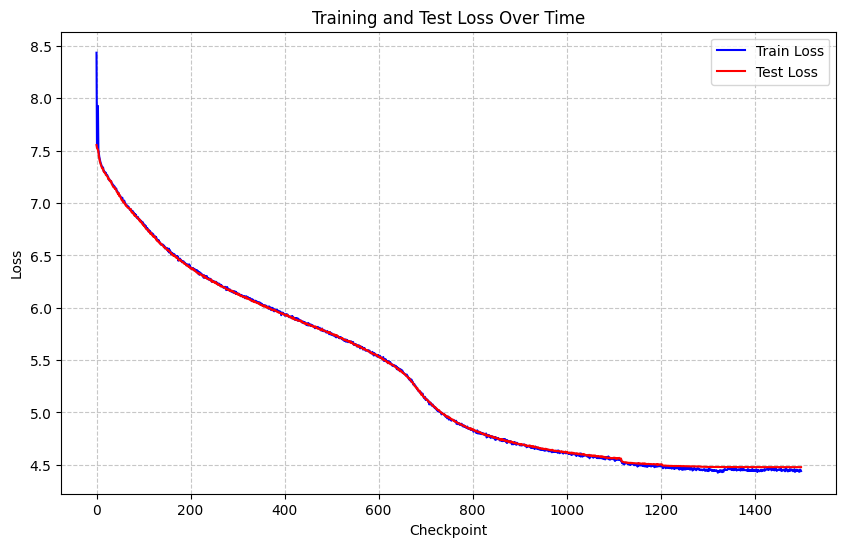

In [18]:
if use_existing_model:
    print("Existing model used, no loss curves shown.")
    plt.imshow(plt.imread("./loss_curve.png"))
else:
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='red')
    plt.xlabel('Checkpoint')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


In [19]:
if not use_existing_model:
    torch.save(model, f"./pretrain_final.pth")

### 1.4.3 Вывод с помощью предварительно обученной модели

Теперь, когда мы предварительно обучили модель, мы можем выполнить несколько примеров вывода, чтобы увидеть, какие типы результатов мы получаем от модели. Мы видим, что модель способна выводить разборчивый английский текст, и большинство слов имеют смысл, однако ее ограниченный размер делает ее не столь надежной, как более крупные модели. Тем не менее, она достаточно хороша, чтобы увидеть «искры» понимания языка.

В этом наборе данных мы обучали модель на новостных статьях, поэтому я начал предложения с фраз, которые потенциально могут встречаться в новостях. Если вы повторно запустите ячейку ниже, вы увидите, что каждый раз получаете разные результаты. Это связано со случайностью следующего этапа выбора токена.

In [20]:
def inference(prompt,torch_model, max_new_tokens):
    torch_model.eval()
    with torch.no_grad():
        tokens = hf_tokenizer.encode(prompt)
        for _ in range(max_new_tokens):
            num_tokens = len(tokens)
            tokens_padded = tokens + [hf_tokenizer.eos_token_id] * (config.seq_len - num_tokens)
            tokens_padded = torch.tensor(tokens_padded).unsqueeze(0).to(device)
            logits = torch_model(tokens_padded)
            probabilities = torch.softmax(logits[0, num_tokens-1, :], dim=-1)
            predicted_token = torch.multinomial(probabilities, 1).item()
            tokens.append(predicted_token)
        return hf_tokenizer.decode(tokens)

In [21]:
print("Predicted:", inference("The president signed a bill to pass", model, max_new_tokens=20))
print("Predicted:", inference("There was a large division in", model, max_new_tokens=20))
print("Predicted:", inference("Reports are showing that", model, max_new_tokens=20))

2025-02-15 09:21:39.354292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 09:21:39.354348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 09:21:39.355365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 09:21:39.361722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-15 09:21:40.186448: W tensorflow/compiler/tf2

Predicted: The president signed a bill to pass the bailout policy, and that's not necessarily in the Democratic Republic." Obama seems to have his closest
Predicted: There was a large division in some kind disguised battles to film Chinese. I voted myself again, but I think the Internet's terms
Predicted: Reports are showing that their advances in optimal traffic culture where each athlete's shift is allowable using drones, an 8-strong


# 2: Supervised Fine Tuning   
Чтобы сделать модель более удобной в использовании, мы можем взять предварительно обученную модель, а затем пройти процесс, называемый контролируемой тонкой настройкой. Этот процесс предполагает наличие высококачественных контролируемых текстовых наборов данных, чтобы модель реагировала так, как мы хотим.

Для этого мы можем использовать набор данных [Fact Q&A](https://huggingface.co/datasets/rubenroy/GammaCorpus-Fact-QA-450k?library=datasets) от huggingface. Этот набор данных состоит из коротких примеров вопросов и ответов, что хорошо подходит для нашего случая использования, поскольку у нас небольшое контекстное окно из 128 токенов.

Контролируемая точная настройка позволяет нам вводить «теги» и другие типы текстовых токенов, которые помогают модели понимать различные роли в тексте. Для нашего набора данных мы будем использовать тег «вопрос» и тег «ответ». Мы добавим все эти теги при создании набора данных, а также во время вывода, когда пользователь отправляет запрос. Мы также добавляем токены eos для завершения/дополнения примеров, которые не занимают все окно контекста.

После тонкой настройки на этом наборе данных в идеале мы получим LLM, которому можно задать вопрос и получить ответ.


In [22]:
# Load dataset in streaming mode
sft_ds = load_dataset("rubenroy/GammaCorpus-Fact-QA-450k", split="train", streaming=True)

def check_sft_dataset_exists():
    try:
        # Attempt to load the dataset with reuse_cache_if_exists mode
        load_dataset("parquet", data_files="fact_qa_train.parquet", split="train")
        load_dataset("parquet", data_files="fact_qa_test.parquet", split="train")
        return True
    except FileNotFoundError:
        return False
    
if not check_sft_dataset_exists():
    print("Tokenized supervised fine tuning dataset does not exist locally... Generating and saving to disk.")

    def tokenize_and_chunk(dataset, tokenizer, chunk_size=512, rows=1000):
        """
        Tokenizes and chunks the dataset into fixed-length 512-token segments.
        The 'target' sequence is shifted left by 1 token.
        Stops after generating `train_rows + test_rows` tokenized chunks.
        """
        row_count = 0

        for example in dataset:
            question_plus_answer = "<Question>" + example["question"] + "</Question>" + "<Answer>" + example["answer"] + "</Answer>"
            input_tokens = tokenizer(question_plus_answer, truncation=False, padding=False)['input_ids']

            if row_count >= rows:
                return

            if len(input_tokens) >= chunk_size:
                continue
            else:
                input_tokens = input_tokens +[tokenizer.eos_token_id] * (chunk_size - len(input_tokens))
            
            target_tokens = input_tokens[1:] + [tokenizer.eos_token_id]  # Shifted by 1 token

            yield {
                "input": input_tokens, 
                "target": target_tokens
            }
            
            row_count += 1

    # Set the max number of rows for training and testing
    TRAIN_ROWS = 440000  # Adjust as needed
    TEST_ROWS = 500   # Adjust as needed
    CHUNK_SIZE = 128

    # Convert generator to a Hugging Face Dataset
    tokenized_sft_dataset = Dataset.from_generator(lambda: tokenize_and_chunk(sft_ds, hf_tokenizer,chunk_size=CHUNK_SIZE, rows=TRAIN_ROWS + TEST_ROWS))

    # Split the dataset into `train` and `test`
    sft_dataset_splits = tokenized_sft_dataset.train_test_split(train_size=TRAIN_ROWS, test_size=TEST_ROWS, seed=42)

    # Save to disk
    sft_dataset_splits["train"].to_parquet("fact_qa_train.parquet")
    sft_dataset_splits["test"].to_parquet("fact_qa_test.parquet")

    print(f"✅ Saved {TRAIN_ROWS} train rows and {TEST_ROWS} test rows for supervised fine tuning.")
else:
    print("SFT Tokenized dataset already exists locally.")

README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

Tokenized supervised fine tuning dataset does not exist locally... Generating and saving to disk.


Generating train split: 0 examples [00:00, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/440 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

✅ Saved 440000 train rows and 500 test rows for supervised fine tuning.


### 2.1 Supervised Fine Tuning Training Loop

Очень похожий цикл обучения можно использовать для контролируемой тонкой настройки.

In [23]:
# Example config:
batch_size = 64
sequence_len = 128
num_steps = 50000
accumulation_steps = 100

# Reload the train and test datasets
train_ds = load_dataset("parquet", data_files="fact_qa_train.parquet", split="train")
test_ds = load_dataset("parquet", data_files="fact_qa_test.parquet", split="train")

# Convert dataset to PyTorch format
train_ds.set_format("torch", columns=["input", "target"])
test_ds.set_format("torch", columns=["input", "target"])

# Create DataLoaders for training and testing
train_dataloader = cycle(DataLoader(train_ds, batch_size=batch_size, shuffle=False))
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


use_existing_model = os.path.exists("./sft_final.pth")
# Check if pre-trained model exists
if use_existing_model:
    model = torch.load("./sft_final.pth")
    print("Loaded fine tuned model from ./sft_final.pth, skipping training loop.")

else:
    # For SFT we start with the pretrained model
    model = torch.load("./pretrain_final.pth")
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


    # Scheduler with dynamic step size
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.2, patience=10, min_lr=5e-6, threshold=1e-4)


    # Training loop
    losses = []
    test_losses = []
    accumulator = 0
    accumulator_loss = 0
    for i in range(num_steps):
        model.train()
        example = next(train_dataloader)
        train_input = example["input"].to(device)
        train_target = example["target"].to(device)
        logits = model(train_input)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), train_target.view(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

        accumulator += 1
        accumulator_loss += loss.item()

        

        if accumulator >= accumulation_steps:
            losses.append(accumulator_loss / accumulation_steps)
            accumulator = 0
            accumulator_loss = 0
            model.eval()
            test_loss = 0
            test_accumulator = 0
            with torch.no_grad():
                for test_example in test_dataloader:
                    test_input = test_example["input"].to(device)
                    test_target = test_example["target"].to(device)
                    test_logits = model(test_input)
                    test_loss += F.cross_entropy(test_logits.view(-1, test_logits.size(-1)), test_target.view(-1)).item()
                    test_accumulator += 1
                test_losses.append(test_loss / test_accumulator)
                print(f"Step {i+1}/{num_steps}, Loss: {losses[-1]}, Test Loss: {test_losses[-1]}")
                test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
                scheduler.step(test_losses[-1])

        if i+1 % 50000 == 0:
            torch.save(model.state_dict(), f"./sft_model_checkpoint_{i}.pt")
        

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Step 100/50000, Loss: 1.9918309170007706, Test Loss: 0.7444852367043495
Step 200/50000, Loss: 0.7175035107135773, Test Loss: 0.7121347188949585
Step 300/50000, Loss: 0.7018899911642075, Test Loss: 0.6949615925550461
Step 400/50000, Loss: 0.6908353179693222, Test Loss: 0.6887291222810745
Step 500/50000, Loss: 0.6768182325363159, Test Loss: 0.6792757734656334
Step 600/50000, Loss: 0.674177388548851, Test Loss: 0.6729135736823082
Step 700/50000, Loss: 0.6727178591489792, Test Loss: 0.665991447865963
Step 800/50000, Loss: 0.6694402080774308, Test Loss: 0.6644480600953102
Step 900/50000, Loss: 0.6582337802648545, Test Loss: 0.6569188311696053
Step 1000/50000, Loss: 0.6548500311374664, Test Loss: 0.6566447466611862
Step 1100/50000, Loss: 0.6548229521512985, Test Loss: 0.651200458407402
Step 1200/50000, Loss: 0.6486632919311524, Test Loss: 0.6475077718496323
Step 1300/50000, Loss: 0.6484963500499725, Test Loss: 0.6474942564964294
Step 1400/50000, Loss: 0.6471871453523635, Test Loss: 0.6445949

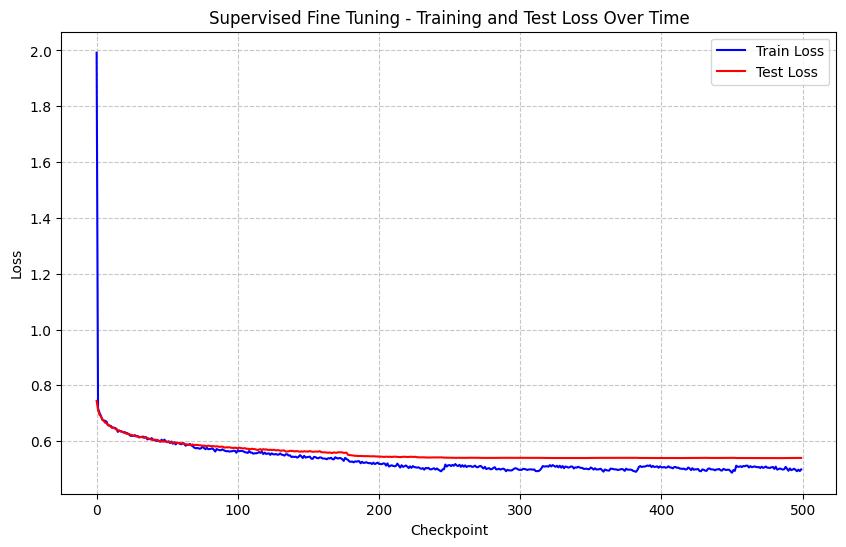

In [24]:
if use_existing_model:
    print("Existing model used, no loss curves shown.")
    plt.imshow(plt.imread("./sft_loss_curve.png"))
else:
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='red')
    plt.xlabel('Checkpoint')
    plt.ylabel('Loss')
    plt.title('Supervised Fine Tuning - Training and Test Loss Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


In [25]:
if not use_existing_model:
    torch.save(model, f"./sft_final.pth")

### 2.2 Вывод с помощью точно настроенной модели

С помощью точно настроенной модели мы можем выполнять более естественную форму вывода. Вместо того, чтобы форматировать все наши подсказки как прогноз следующего токена, мы можем использовать более естественный формат вопросов и ответов с помощью модели.    

Мы используем очень маленькую модель и очень маленький набор данных по сравнению с современными LLM, поэтому наша модель не будет работать очень хорошо с большинством вопросов. Однако она выдает ответы, которые, по крайней мере, связаны с подсказкой и отформатированы правильным образом. Очень круто видеть, как LLM начинает складываться! По мере увеличения масштаба модели, данных и т. д. ответы будут становиться более фактическими, реалистичными и контекстуально точными. На данный момент большинство ответов являются галлюцинациями.

In [26]:
def sft_inference(prompt,torch_model, max_new_tokens):
    torch_model.eval()
    prompt = "<Question>" + prompt + "</Question>" + "<Answer>" # Wrap the prompt in <Question> and start inference with <Answer>
    with torch.no_grad(): 
        tokens = hf_tokenizer.encode(prompt) # Tokenize the prompt
        for _ in range(max_new_tokens):
            if tokens[-1] == hf_tokenizer.eos_token_id: # Stop if we reach the end of the sequence
                break
            num_tokens = len(tokens) # 
            tokens_padded = tokens + [hf_tokenizer.eos_token_id] * (config.seq_len - num_tokens) # pad the sequence with eos token
            tokens_padded = torch.tensor(tokens_padded).unsqueeze(0).to(device) 
            logits = torch_model(tokens_padded) # Forward pass through the model
            probabilities = torch.softmax(logits[0, num_tokens-1, :], dim=-1) # Get the probabilities of the last token
            predicted_token = torch.argmax(probabilities).item() # Greedy decoding, change to sampling for more diversity
            tokens.append(predicted_token)
        
        # Strip the text to between the <Answer></Answer> tags
        full_answer = hf_tokenizer.decode(tokens)
        answer_start = full_answer.find("<Answer>") + len("<Answer>")
        answer_end = full_answer.find("</Answer>")
        return full_answer[answer_start:answer_end]

In [ ]:
print("Predicted:", sft_inference("Who is the most powerful leader in the west?", model, max_new_tokens=20))
print("Predicted:", sft_inference("What color is the sun?", model, max_new_tokens=20))
print("Predicted:", sft_inference("What color is the ocean", model, max_new_tokens=20))
print("Predicted:", sft_inference("How many planets are in the solar system", model, max_new_tokens=20))
print("Predicted:", sft_inference("What three countries are in north america?", model, max_new_tokens=20))
print("Predicted:", sft_inference("How many eyes do humans have?", model, max_new_tokens=20))


Predicted: The President of the Republic of the Republic of the Congo
Predicted: Yellow
Predicted: Red
Predicted: Two
Predicted: United States and Canada
Predicted: Two-four-four-four-four-four-four-four-four-four
